In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 7]

from IPython.display import clear_output
from time import sleep

In [2]:
class TaxiEnv:

    def __init__(self, method, alpha, temperature, env, gamma):
        self.env = env
        self.method = method
        self.positions = 25
        self.num_ps_location = 5
        self.num_ps_destination = 4
        self.num_states = self.positions * self.num_ps_location * self.num_ps_destination
        self.num_actions = 6
        self.alpha = alpha
        self.gamma = gamma
        self.temperature = temperature
        # initialize q table
        self.q = np.zeros(shape=(self.num_states, self.num_actions))
        # initialize policy
        self.pi = np.zeros_like(self.q)

    def interact(self):
        state = self.env.reset()
        delivered = False
        r_sum = 0
        steps = 0
        while not delivered:
            steps += 1
            action, probs = self._take_action(state)
            next_state, reward, delivered, info = self.env.step(action)

            if self.method == 'sarsa':
                next_action = self._take_action(next_state)[0]
                self.q[state][action] += self.alpha * \
                                         (reward + self.gamma * self.q[next_state][next_action] - self.q[state][action])
            elif self.method == 'q_learning':
                next_action = np.random.choice(np.where(self.q[next_state] == max(self.q[next_state]))[0])
                self.q[state][action] += self.alpha * \
                                         (reward + self.gamma * self.q[next_state][next_action] - self.q[state][action])
            elif self.method == 'expected_sarsa':
                self.q[state][action] += self.alpha * (reward + self.gamma * np.dot(probs, self.q[next_state][:])
                                                       - self.q[state][action])

            r_sum += reward
            state = next_state
        return r_sum

    def _take_action(self, state):
        self.pi[state] = np.exp(self.q[state] / self.temperature)
        prob = np.true_divide(self.pi[state], sum(self.pi[state]))
        a = np.random.choice(np.arange(6), p=prob)
        return a, prob

    def run_optimal_policy(self):
        state = self.env.reset()
        delivered = False
        r_sum = 0
        steps = 0
        while delivered == False:
            steps += 1
            action = np.random.choice(np.where(self.q[state] == max(self.q[state]))[0])
            next_state, reward, delivered, info = self.env.step(action)
            r_sum += reward
            state = next_state

            if delivered:
                print(end="")

        return r_sum

    def train(self, print_trace=False):
        runs = 10
        segments = 100
        episodes = 10

        train_rewards = []
        test_rewards = []

        reward_train_episodes = []
        reward_test_episode = []
        all_test_rewards = np.zeros(shape=(runs, segments))

        for run in range(runs):
            self.q = np.zeros(shape=(self.num_states, self.num_actions))
            for segment in range(segments):
                train_rewards = []
                for episode in range(episodes + 1):
                    if episode < episodes:
                        reward_sum = self.interact()
                        train_rewards.append(reward_sum)
                    else:
                        test_reward = self.run_optimal_policy()
                        test_rewards.append(test_reward)
                    if print_trace:
                        if episode == episodes:
                            all_test_rewards[run][segment] = test_rewards[-1]
                            if segment % 10 == 0 or segment == 99:
                                print('{} | alpha {}, tau {:3.2f} | Run {:2d}, Segment {:2d}'.
                                      format(self.method, self.alpha, self.temperature, run, segment), end=" ")
                                print('| train reward {:8.2f}, test_reward {}'.
                                      format(np.mean(train_rewards[episode - 10:episode]), test_rewards[-1]))
                    if episode == episodes and segment == segments - 1:  # last segment, last episode
                        reward_train_episodes.append(np.mean(train_rewards))
                        reward_test_episode.append(test_rewards[-1])

        train_per_run = np.mean(reward_train_episodes)    # for the first bullet in the question
        test_per_run = np.mean(reward_test_episode)       # for the second bullet in the question
        avg_test_reward_per_run = np.mean(all_test_rewards, axis=0)  # for the third bullet in the question
        std_test_reward_per_run = np.std(all_test_rewards, axis=0)   # for the third bullet in the question

        return train_per_run, test_per_run, avg_test_reward_per_run, std_test_reward_per_run

In [3]:
env = gym.make('Taxi-v2')

learning_rates = [0.3, 0.5, 0.8]
temperatures = [0.5, 1, 1.5]

In [4]:
def plot_graph(x_value, y_values, legend_names, x_axis_title, y_axis_title, filename_to_save):
    fig = plt.figure(1)
    ax = fig.add_subplot(1, 1, 1)
    for i in range(len(y_values)):
        ax.plot(x_value,
                y_values[i],
                label=legend_names[i])
    ax.set_xlabel(x_axis_title)
    ax.set_ylabel(y_axis_title)

    plt.legend(loc='upper left')
#     if saveFigures:
    plt.savefig(filename_to_save)
#     if plot_graph_:
    plt.show()
    plt.clf()

In [5]:
def plot_error(x, y, e, alpha, tau):
    fig, ax = plt.subplots()
    ax.errorbar(x, y, e,  linestyle='solid', marker='o')
    ax.set_title('Learning curve for alpha {} - tau {}'.format(alpha, tau))
    ax.set_xlabel('Segments')
    ax.set_ylabel('Mean and Std test rewards')
    plt.show()

sarsa | alpha 0.3, tau 0.50 | Run  0, Segment  0 | train reward  -467.60, test_reward -2000
sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 10 | train reward  -170.30, test_reward -200
sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 20 | train reward   -99.00, test_reward -200
sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 30 | train reward   -63.30, test_reward -200
sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 40 | train reward   -41.40, test_reward -200
sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 50 | train reward    -9.80, test_reward 6
sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 60 | train reward     6.40, test_reward 9
sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 70 | train reward     6.00, test_reward 8
sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 80 | train reward     6.60, test_reward 9
sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 90 | train reward     6.60, test_reward 8
sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 99 | train reward    10.30, test_reward -200
sarsa | alpha

sarsa | alpha 0.3, tau 0.50 | Run  8, Segment 40 | train reward   -45.10, test_reward -200
sarsa | alpha 0.3, tau 0.50 | Run  8, Segment 50 | train reward    -7.50, test_reward -200
sarsa | alpha 0.3, tau 0.50 | Run  8, Segment 60 | train reward     3.70, test_reward 7
sarsa | alpha 0.3, tau 0.50 | Run  8, Segment 70 | train reward     6.90, test_reward -200
sarsa | alpha 0.3, tau 0.50 | Run  8, Segment 80 | train reward     5.70, test_reward -200
sarsa | alpha 0.3, tau 0.50 | Run  8, Segment 90 | train reward     7.30, test_reward 9
sarsa | alpha 0.3, tau 0.50 | Run  8, Segment 99 | train reward     8.30, test_reward 5
sarsa | alpha 0.3, tau 0.50 | Run  9, Segment  0 | train reward  -499.30, test_reward -200
sarsa | alpha 0.3, tau 0.50 | Run  9, Segment 10 | train reward  -173.50, test_reward -200
sarsa | alpha 0.3, tau 0.50 | Run  9, Segment 20 | train reward  -144.70, test_reward -200
sarsa | alpha 0.3, tau 0.50 | Run  9, Segment 30 | train reward   -75.50, test_reward -200
sarsa | 

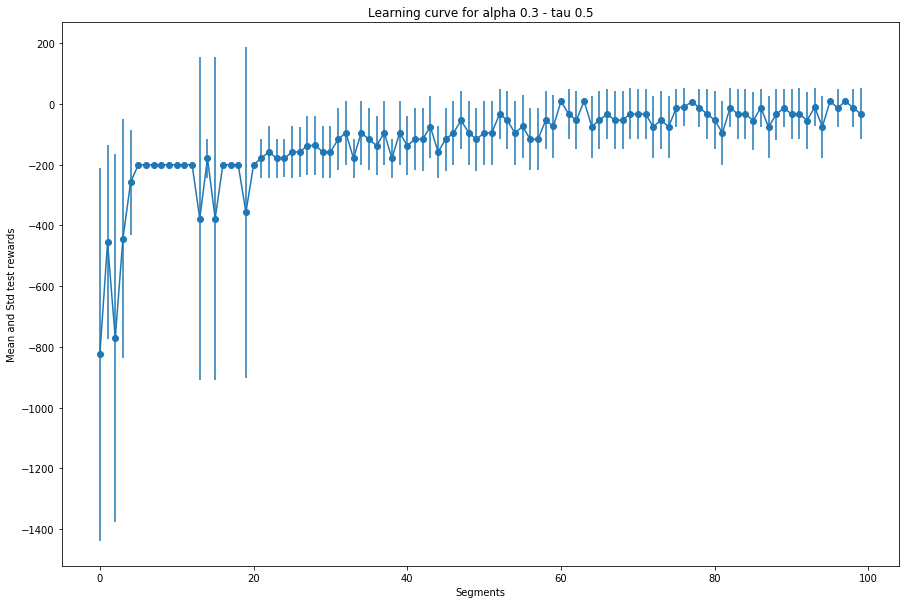

sarsa | alpha 0.5, tau 0.50 | Run  0, Segment  0 | train reward  -460.00, test_reward -200
sarsa | alpha 0.5, tau 0.50 | Run  0, Segment 10 | train reward  -117.10, test_reward -200
sarsa | alpha 0.5, tau 0.50 | Run  0, Segment 20 | train reward   -86.00, test_reward -200
sarsa | alpha 0.5, tau 0.50 | Run  0, Segment 30 | train reward   -23.70, test_reward 11
sarsa | alpha 0.5, tau 0.50 | Run  0, Segment 40 | train reward    -1.80, test_reward 9
sarsa | alpha 0.5, tau 0.50 | Run  0, Segment 50 | train reward     6.50, test_reward 10
sarsa | alpha 0.5, tau 0.50 | Run  0, Segment 60 | train reward     6.80, test_reward 7
sarsa | alpha 0.5, tau 0.50 | Run  0, Segment 70 | train reward     6.80, test_reward 7
sarsa | alpha 0.5, tau 0.50 | Run  0, Segment 80 | train reward     8.30, test_reward 8
sarsa | alpha 0.5, tau 0.50 | Run  0, Segment 90 | train reward     9.50, test_reward 8
sarsa | alpha 0.5, tau 0.50 | Run  0, Segment 99 | train reward     8.60, test_reward 8
sarsa | alpha 0.5, ta

sarsa | alpha 0.5, tau 0.50 | Run  8, Segment 40 | train reward    -9.10, test_reward 9
sarsa | alpha 0.5, tau 0.50 | Run  8, Segment 50 | train reward     5.40, test_reward 10
sarsa | alpha 0.5, tau 0.50 | Run  8, Segment 60 | train reward    10.70, test_reward 7
sarsa | alpha 0.5, tau 0.50 | Run  8, Segment 70 | train reward     7.40, test_reward -200
sarsa | alpha 0.5, tau 0.50 | Run  8, Segment 80 | train reward     6.00, test_reward 7
sarsa | alpha 0.5, tau 0.50 | Run  8, Segment 90 | train reward     7.30, test_reward 7
sarsa | alpha 0.5, tau 0.50 | Run  8, Segment 99 | train reward     8.80, test_reward 13
sarsa | alpha 0.5, tau 0.50 | Run  9, Segment  0 | train reward  -470.00, test_reward -875
sarsa | alpha 0.5, tau 0.50 | Run  9, Segment 10 | train reward  -170.70, test_reward -200
sarsa | alpha 0.5, tau 0.50 | Run  9, Segment 20 | train reward    -8.80, test_reward -200
sarsa | alpha 0.5, tau 0.50 | Run  9, Segment 30 | train reward    -5.70, test_reward -200
sarsa | alpha 0

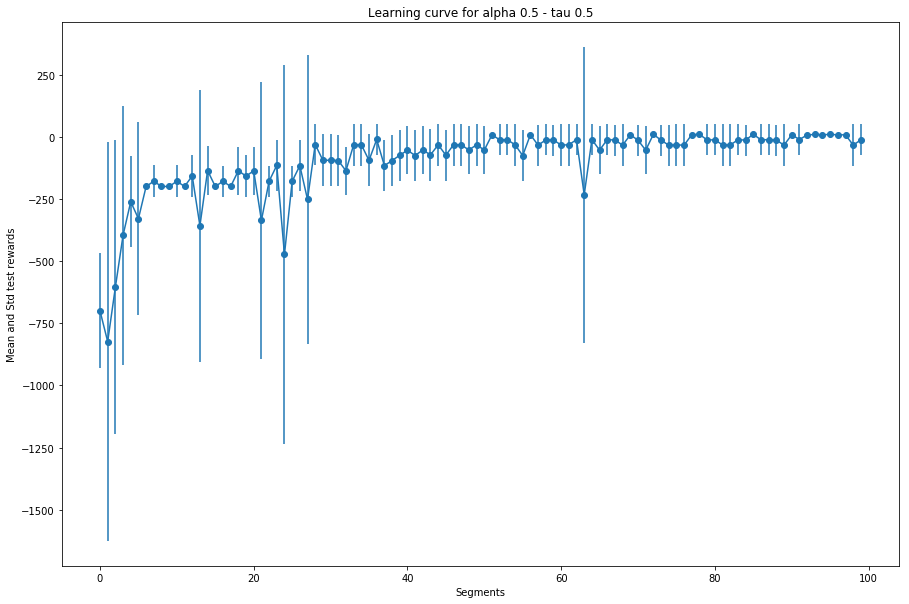

sarsa | alpha 0.8, tau 0.50 | Run  0, Segment  0 | train reward  -487.10, test_reward -749
sarsa | alpha 0.8, tau 0.50 | Run  0, Segment 10 | train reward   -44.20, test_reward -200
sarsa | alpha 0.8, tau 0.50 | Run  0, Segment 20 | train reward    -1.60, test_reward 9
sarsa | alpha 0.8, tau 0.50 | Run  0, Segment 30 | train reward     2.40, test_reward 9
sarsa | alpha 0.8, tau 0.50 | Run  0, Segment 40 | train reward     6.10, test_reward 9
sarsa | alpha 0.8, tau 0.50 | Run  0, Segment 50 | train reward     6.80, test_reward 11
sarsa | alpha 0.8, tau 0.50 | Run  0, Segment 60 | train reward     4.80, test_reward 10
sarsa | alpha 0.8, tau 0.50 | Run  0, Segment 70 | train reward     7.20, test_reward 5
sarsa | alpha 0.8, tau 0.50 | Run  0, Segment 80 | train reward     7.90, test_reward 8
sarsa | alpha 0.8, tau 0.50 | Run  0, Segment 90 | train reward     7.40, test_reward 10
sarsa | alpha 0.8, tau 0.50 | Run  0, Segment 99 | train reward     8.50, test_reward 5
sarsa | alpha 0.8, tau 

sarsa | alpha 0.8, tau 0.50 | Run  8, Segment 40 | train reward     2.20, test_reward 11
sarsa | alpha 0.8, tau 0.50 | Run  8, Segment 50 | train reward     5.60, test_reward 11
sarsa | alpha 0.8, tau 0.50 | Run  8, Segment 60 | train reward     6.70, test_reward 6
sarsa | alpha 0.8, tau 0.50 | Run  8, Segment 70 | train reward     6.70, test_reward 8
sarsa | alpha 0.8, tau 0.50 | Run  8, Segment 80 | train reward     6.80, test_reward 6
sarsa | alpha 0.8, tau 0.50 | Run  8, Segment 90 | train reward     5.20, test_reward 2
sarsa | alpha 0.8, tau 0.50 | Run  8, Segment 99 | train reward     6.80, test_reward 7
sarsa | alpha 0.8, tau 0.50 | Run  9, Segment  0 | train reward  -470.90, test_reward -767
sarsa | alpha 0.8, tau 0.50 | Run  9, Segment 10 | train reward   -83.30, test_reward -200
sarsa | alpha 0.8, tau 0.50 | Run  9, Segment 20 | train reward   -14.70, test_reward 12
sarsa | alpha 0.8, tau 0.50 | Run  9, Segment 30 | train reward    -7.90, test_reward 8
sarsa | alpha 0.8, tau 

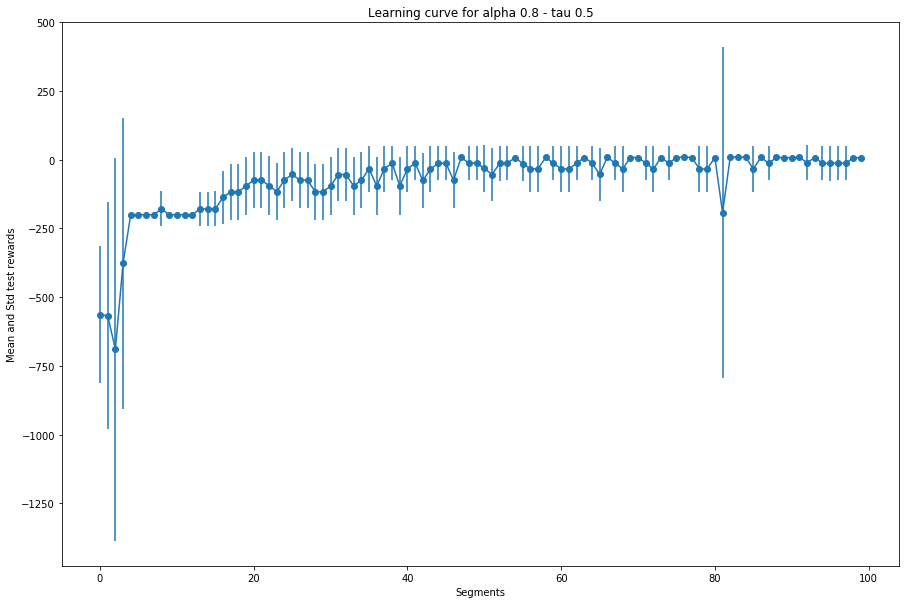

sarsa | alpha 0.3, tau 1.00 | Run  0, Segment  0 | train reward  -490.00, test_reward -749
sarsa | alpha 0.3, tau 1.00 | Run  0, Segment 10 | train reward  -151.30, test_reward -200
sarsa | alpha 0.3, tau 1.00 | Run  0, Segment 20 | train reward  -102.80, test_reward -200
sarsa | alpha 0.3, tau 1.00 | Run  0, Segment 30 | train reward   -72.60, test_reward -200
sarsa | alpha 0.3, tau 1.00 | Run  0, Segment 40 | train reward   -27.60, test_reward -200
sarsa | alpha 0.3, tau 1.00 | Run  0, Segment 50 | train reward   -15.20, test_reward -200
sarsa | alpha 0.3, tau 1.00 | Run  0, Segment 60 | train reward     1.20, test_reward 13
sarsa | alpha 0.3, tau 1.00 | Run  0, Segment 70 | train reward     5.50, test_reward -200
sarsa | alpha 0.3, tau 1.00 | Run  0, Segment 80 | train reward     3.00, test_reward 11
sarsa | alpha 0.3, tau 1.00 | Run  0, Segment 90 | train reward     3.20, test_reward 12
sarsa | alpha 0.3, tau 1.00 | Run  0, Segment 99 | train reward     2.50, test_reward 8
sarsa | 

sarsa | alpha 0.3, tau 1.00 | Run  8, Segment 40 | train reward   -35.20, test_reward -200
sarsa | alpha 0.3, tau 1.00 | Run  8, Segment 50 | train reward    -7.30, test_reward -200
sarsa | alpha 0.3, tau 1.00 | Run  8, Segment 60 | train reward   -12.60, test_reward 10
sarsa | alpha 0.3, tau 1.00 | Run  8, Segment 70 | train reward     2.30, test_reward -200
sarsa | alpha 0.3, tau 1.00 | Run  8, Segment 80 | train reward     7.80, test_reward 11
sarsa | alpha 0.3, tau 1.00 | Run  8, Segment 90 | train reward     6.10, test_reward 8
sarsa | alpha 0.3, tau 1.00 | Run  8, Segment 99 | train reward     6.60, test_reward 8
sarsa | alpha 0.3, tau 1.00 | Run  9, Segment  0 | train reward  -426.00, test_reward -812
sarsa | alpha 0.3, tau 1.00 | Run  9, Segment 10 | train reward  -218.40, test_reward -200
sarsa | alpha 0.3, tau 1.00 | Run  9, Segment 20 | train reward  -175.50, test_reward -200
sarsa | alpha 0.3, tau 1.00 | Run  9, Segment 30 | train reward   -55.20, test_reward -200
sarsa | a

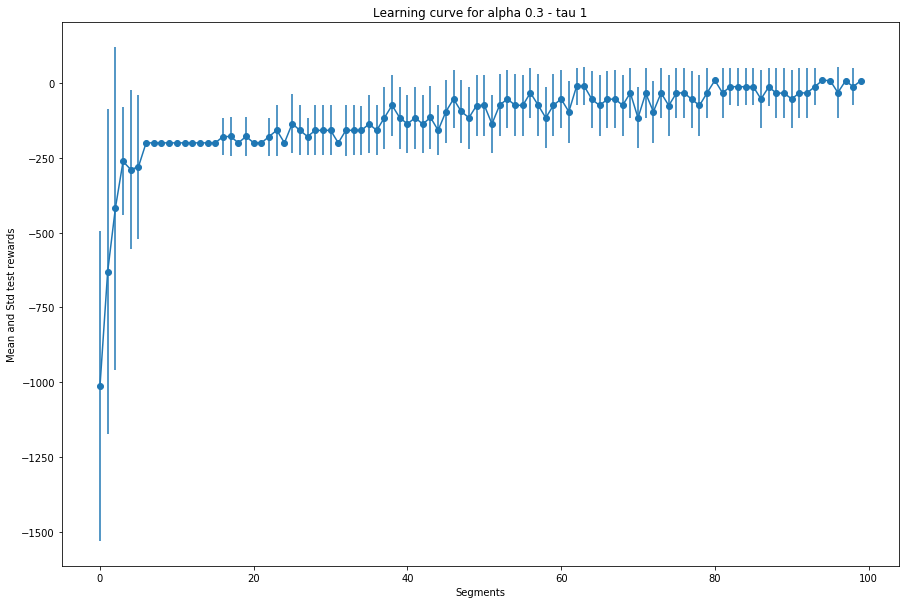

sarsa | alpha 0.5, tau 1.00 | Run  0, Segment  0 | train reward  -504.20, test_reward -848
sarsa | alpha 0.5, tau 1.00 | Run  0, Segment 10 | train reward  -199.60, test_reward -200
sarsa | alpha 0.5, tau 1.00 | Run  0, Segment 20 | train reward  -119.30, test_reward -200
sarsa | alpha 0.5, tau 1.00 | Run  0, Segment 30 | train reward   -36.90, test_reward -200
sarsa | alpha 0.5, tau 1.00 | Run  0, Segment 40 | train reward   -10.00, test_reward -200
sarsa | alpha 0.5, tau 1.00 | Run  0, Segment 50 | train reward     2.10, test_reward 10
sarsa | alpha 0.5, tau 1.00 | Run  0, Segment 60 | train reward     4.10, test_reward 7
sarsa | alpha 0.5, tau 1.00 | Run  0, Segment 70 | train reward    -0.70, test_reward 5
sarsa | alpha 0.5, tau 1.00 | Run  0, Segment 80 | train reward     7.50, test_reward 10
sarsa | alpha 0.5, tau 1.00 | Run  0, Segment 90 | train reward     6.80, test_reward 10
sarsa | alpha 0.5, tau 1.00 | Run  0, Segment 99 | train reward     7.30, test_reward 4
sarsa | alpha 

sarsa | alpha 0.5, tau 1.00 | Run  8, Segment 40 | train reward    -6.40, test_reward 8
sarsa | alpha 0.5, tau 1.00 | Run  8, Segment 50 | train reward     1.50, test_reward 5
sarsa | alpha 0.5, tau 1.00 | Run  8, Segment 60 | train reward     7.90, test_reward 8
sarsa | alpha 0.5, tau 1.00 | Run  8, Segment 70 | train reward     3.30, test_reward 12
sarsa | alpha 0.5, tau 1.00 | Run  8, Segment 80 | train reward     7.60, test_reward 10
sarsa | alpha 0.5, tau 1.00 | Run  8, Segment 90 | train reward     6.90, test_reward 8
sarsa | alpha 0.5, tau 1.00 | Run  8, Segment 99 | train reward     7.60, test_reward 8
sarsa | alpha 0.5, tau 1.00 | Run  9, Segment  0 | train reward  -473.30, test_reward -1046
sarsa | alpha 0.5, tau 1.00 | Run  9, Segment 10 | train reward  -148.60, test_reward -200
sarsa | alpha 0.5, tau 1.00 | Run  9, Segment 20 | train reward   -65.20, test_reward -200
sarsa | alpha 0.5, tau 1.00 | Run  9, Segment 30 | train reward   -25.10, test_reward -200
sarsa | alpha 0.5

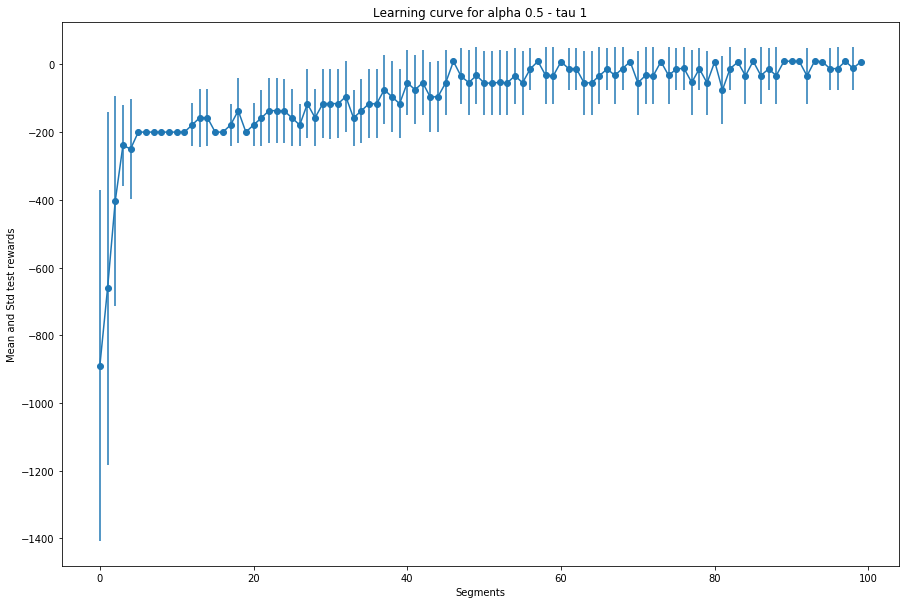

sarsa | alpha 0.8, tau 1.00 | Run  0, Segment  0 | train reward  -477.70, test_reward -1244
sarsa | alpha 0.8, tau 1.00 | Run  0, Segment 10 | train reward   -81.50, test_reward -200
sarsa | alpha 0.8, tau 1.00 | Run  0, Segment 20 | train reward   -61.60, test_reward 9
sarsa | alpha 0.8, tau 1.00 | Run  0, Segment 30 | train reward   -12.30, test_reward -200
sarsa | alpha 0.8, tau 1.00 | Run  0, Segment 40 | train reward    -5.60, test_reward 5
sarsa | alpha 0.8, tau 1.00 | Run  0, Segment 50 | train reward     3.90, test_reward 8
sarsa | alpha 0.8, tau 1.00 | Run  0, Segment 60 | train reward     3.00, test_reward 6
sarsa | alpha 0.8, tau 1.00 | Run  0, Segment 70 | train reward     9.10, test_reward 11
sarsa | alpha 0.8, tau 1.00 | Run  0, Segment 80 | train reward     6.50, test_reward 8
sarsa | alpha 0.8, tau 1.00 | Run  0, Segment 90 | train reward     5.00, test_reward 6
sarsa | alpha 0.8, tau 1.00 | Run  0, Segment 99 | train reward     5.80, test_reward 13
sarsa | alpha 0.8, t

sarsa | alpha 0.8, tau 1.00 | Run  8, Segment 40 | train reward     6.10, test_reward 5
sarsa | alpha 0.8, tau 1.00 | Run  8, Segment 50 | train reward     6.50, test_reward 10
sarsa | alpha 0.8, tau 1.00 | Run  8, Segment 60 | train reward     5.70, test_reward 4
sarsa | alpha 0.8, tau 1.00 | Run  8, Segment 70 | train reward     7.00, test_reward 12
sarsa | alpha 0.8, tau 1.00 | Run  8, Segment 80 | train reward     7.80, test_reward 10
sarsa | alpha 0.8, tau 1.00 | Run  8, Segment 90 | train reward     8.40, test_reward 13
sarsa | alpha 0.8, tau 1.00 | Run  8, Segment 99 | train reward     7.80, test_reward 6
sarsa | alpha 0.8, tau 1.00 | Run  9, Segment  0 | train reward  -474.20, test_reward -776
sarsa | alpha 0.8, tau 1.00 | Run  9, Segment 10 | train reward  -167.20, test_reward -200
sarsa | alpha 0.8, tau 1.00 | Run  9, Segment 20 | train reward   -96.30, test_reward -200
sarsa | alpha 0.8, tau 1.00 | Run  9, Segment 30 | train reward    -3.90, test_reward 11
sarsa | alpha 0.8,

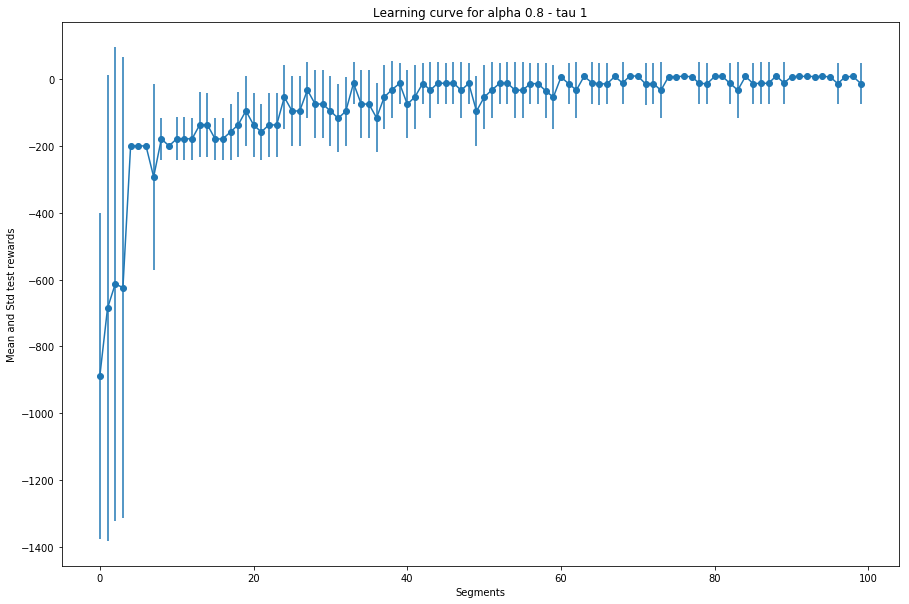

sarsa | alpha 0.3, tau 1.50 | Run  0, Segment  0 | train reward  -540.80, test_reward -197
sarsa | alpha 0.3, tau 1.50 | Run  0, Segment 10 | train reward  -206.50, test_reward -200
sarsa | alpha 0.3, tau 1.50 | Run  0, Segment 20 | train reward  -187.00, test_reward -200
sarsa | alpha 0.3, tau 1.50 | Run  0, Segment 30 | train reward   -71.90, test_reward -200
sarsa | alpha 0.3, tau 1.50 | Run  0, Segment 40 | train reward   -67.90, test_reward 9
sarsa | alpha 0.3, tau 1.50 | Run  0, Segment 50 | train reward    -8.40, test_reward 10
sarsa | alpha 0.3, tau 1.50 | Run  0, Segment 60 | train reward   -47.30, test_reward 8
sarsa | alpha 0.3, tau 1.50 | Run  0, Segment 70 | train reward   -18.60, test_reward -200
sarsa | alpha 0.3, tau 1.50 | Run  0, Segment 80 | train reward     1.20, test_reward 9
sarsa | alpha 0.3, tau 1.50 | Run  0, Segment 90 | train reward     6.60, test_reward 12
sarsa | alpha 0.3, tau 1.50 | Run  0, Segment 99 | train reward     2.90, test_reward 7
sarsa | alpha 0

sarsa | alpha 0.3, tau 1.50 | Run  8, Segment 40 | train reward   -74.20, test_reward 10
sarsa | alpha 0.3, tau 1.50 | Run  8, Segment 50 | train reward   -97.50, test_reward -200
sarsa | alpha 0.3, tau 1.50 | Run  8, Segment 60 | train reward   -25.00, test_reward -200
sarsa | alpha 0.3, tau 1.50 | Run  8, Segment 70 | train reward   -35.10, test_reward -200
sarsa | alpha 0.3, tau 1.50 | Run  8, Segment 80 | train reward     9.70, test_reward 8
sarsa | alpha 0.3, tau 1.50 | Run  8, Segment 90 | train reward    -4.30, test_reward 6
sarsa | alpha 0.3, tau 1.50 | Run  8, Segment 99 | train reward     5.80, test_reward 8
sarsa | alpha 0.3, tau 1.50 | Run  9, Segment  0 | train reward  -515.00, test_reward -1937
sarsa | alpha 0.3, tau 1.50 | Run  9, Segment 10 | train reward  -283.20, test_reward -200
sarsa | alpha 0.3, tau 1.50 | Run  9, Segment 20 | train reward  -207.50, test_reward -200
sarsa | alpha 0.3, tau 1.50 | Run  9, Segment 30 | train reward  -125.50, test_reward -200
sarsa | a

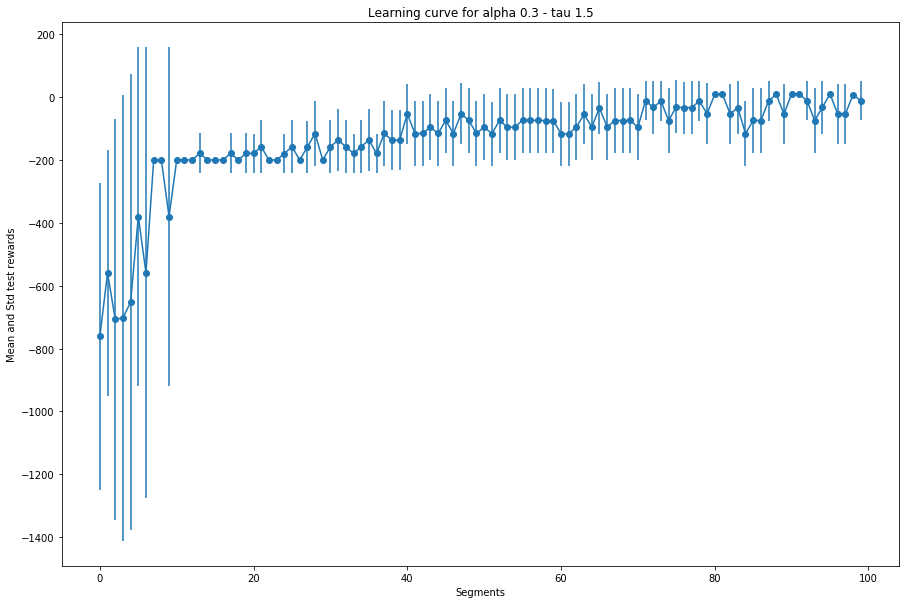

sarsa | alpha 0.5, tau 1.50 | Run  0, Segment  0 | train reward  -506.40, test_reward -1046
sarsa | alpha 0.5, tau 1.50 | Run  0, Segment 10 | train reward  -182.20, test_reward -200
sarsa | alpha 0.5, tau 1.50 | Run  0, Segment 20 | train reward  -136.10, test_reward -200
sarsa | alpha 0.5, tau 1.50 | Run  0, Segment 30 | train reward   -36.80, test_reward 12
sarsa | alpha 0.5, tau 1.50 | Run  0, Segment 40 | train reward   -11.00, test_reward 11
sarsa | alpha 0.5, tau 1.50 | Run  0, Segment 50 | train reward    -0.60, test_reward 13
sarsa | alpha 0.5, tau 1.50 | Run  0, Segment 60 | train reward     5.90, test_reward 8
sarsa | alpha 0.5, tau 1.50 | Run  0, Segment 70 | train reward     1.60, test_reward 7
sarsa | alpha 0.5, tau 1.50 | Run  0, Segment 80 | train reward     2.40, test_reward 8
sarsa | alpha 0.5, tau 1.50 | Run  0, Segment 90 | train reward    -5.00, test_reward 4
sarsa | alpha 0.5, tau 1.50 | Run  0, Segment 99 | train reward     4.90, test_reward 8
sarsa | alpha 0.5, 

sarsa | alpha 0.5, tau 1.50 | Run  8, Segment 40 | train reward   -16.90, test_reward 10
sarsa | alpha 0.5, tau 1.50 | Run  8, Segment 50 | train reward     4.80, test_reward 11
sarsa | alpha 0.5, tau 1.50 | Run  8, Segment 60 | train reward     8.00, test_reward 8
sarsa | alpha 0.5, tau 1.50 | Run  8, Segment 70 | train reward     5.70, test_reward 14
sarsa | alpha 0.5, tau 1.50 | Run  8, Segment 80 | train reward     7.50, test_reward -200
sarsa | alpha 0.5, tau 1.50 | Run  8, Segment 90 | train reward     4.20, test_reward 6
sarsa | alpha 0.5, tau 1.50 | Run  8, Segment 99 | train reward     9.40, test_reward 8
sarsa | alpha 0.5, tau 1.50 | Run  9, Segment  0 | train reward  -471.20, test_reward -2000
sarsa | alpha 0.5, tau 1.50 | Run  9, Segment 10 | train reward  -193.60, test_reward -200
sarsa | alpha 0.5, tau 1.50 | Run  9, Segment 20 | train reward   -56.80, test_reward -200
sarsa | alpha 0.5, tau 1.50 | Run  9, Segment 30 | train reward   -56.00, test_reward 12
sarsa | alpha 0

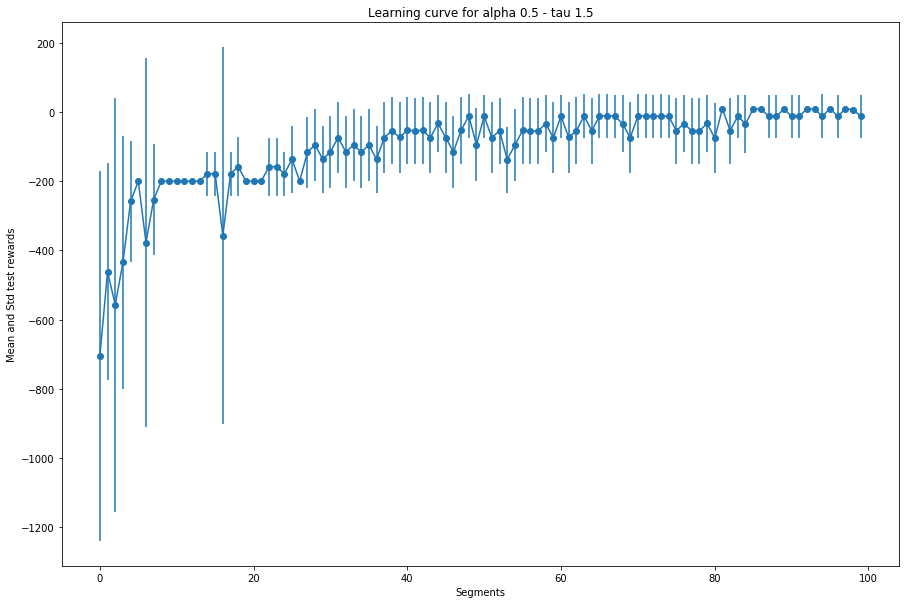

sarsa | alpha 0.8, tau 1.50 | Run  0, Segment  0 | train reward  -429.90, test_reward -974
sarsa | alpha 0.8, tau 1.50 | Run  0, Segment 10 | train reward  -206.00, test_reward -200
sarsa | alpha 0.8, tau 1.50 | Run  0, Segment 20 | train reward   -37.90, test_reward 11
sarsa | alpha 0.8, tau 1.50 | Run  0, Segment 30 | train reward    -1.00, test_reward 7
sarsa | alpha 0.8, tau 1.50 | Run  0, Segment 40 | train reward     4.90, test_reward 7
sarsa | alpha 0.8, tau 1.50 | Run  0, Segment 50 | train reward     4.60, test_reward 10
sarsa | alpha 0.8, tau 1.50 | Run  0, Segment 60 | train reward     4.50, test_reward 11
sarsa | alpha 0.8, tau 1.50 | Run  0, Segment 70 | train reward     6.50, test_reward 8
sarsa | alpha 0.8, tau 1.50 | Run  0, Segment 80 | train reward     3.50, test_reward 10
sarsa | alpha 0.8, tau 1.50 | Run  0, Segment 90 | train reward     1.90, test_reward 14
sarsa | alpha 0.8, tau 1.50 | Run  0, Segment 99 | train reward     4.50, test_reward 11
sarsa | alpha 0.8, t

sarsa | alpha 0.8, tau 1.50 | Run  8, Segment 50 | train reward     6.20, test_reward 7
sarsa | alpha 0.8, tau 1.50 | Run  8, Segment 60 | train reward     5.80, test_reward -200
sarsa | alpha 0.8, tau 1.50 | Run  8, Segment 70 | train reward     7.10, test_reward 5
sarsa | alpha 0.8, tau 1.50 | Run  8, Segment 80 | train reward     5.50, test_reward 5
sarsa | alpha 0.8, tau 1.50 | Run  8, Segment 90 | train reward     6.50, test_reward 7
sarsa | alpha 0.8, tau 1.50 | Run  8, Segment 99 | train reward     7.90, test_reward 6
sarsa | alpha 0.8, tau 1.50 | Run  9, Segment  0 | train reward  -466.30, test_reward -821
sarsa | alpha 0.8, tau 1.50 | Run  9, Segment 10 | train reward  -135.90, test_reward -200
sarsa | alpha 0.8, tau 1.50 | Run  9, Segment 20 | train reward   -61.60, test_reward -200
sarsa | alpha 0.8, tau 1.50 | Run  9, Segment 30 | train reward    -5.80, test_reward 5
sarsa | alpha 0.8, tau 1.50 | Run  9, Segment 40 | train reward   -10.00, test_reward -200
sarsa | alpha 0.8

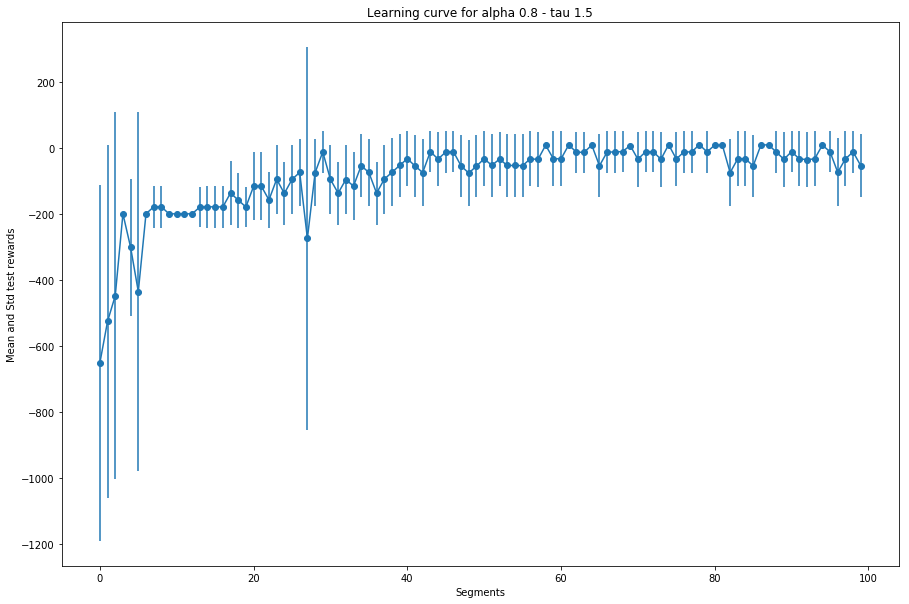

In [12]:
agents = ['sarsa']
for agent in agents:
    agent_train_rewards = np.zeros(shape=(len(temperatures), len(learning_rates)))
    agent_test_rewards = np.zeros_like(agent_train_rewards)
    for temp in temperatures:
        for learning_rate in learning_rates:
            agent_object = TaxiEnv(agent, learning_rate, temp, env, gamma=0.9)
            train_rewards, test_rewards, avg_test, std_test = agent_object.train(print_trace=True)
            agent_train_rewards[temperatures.index(temp)][learning_rates.index(learning_rate)] = train_rewards
            agent_test_rewards[temperatures.index(temp)][learning_rates.index(learning_rate)] = test_rewards
            
            plt.rcParams['figure.figsize'] = [15, 10]
            plot_error(np.arange(100), avg_test, std_test, learning_rate, temp)

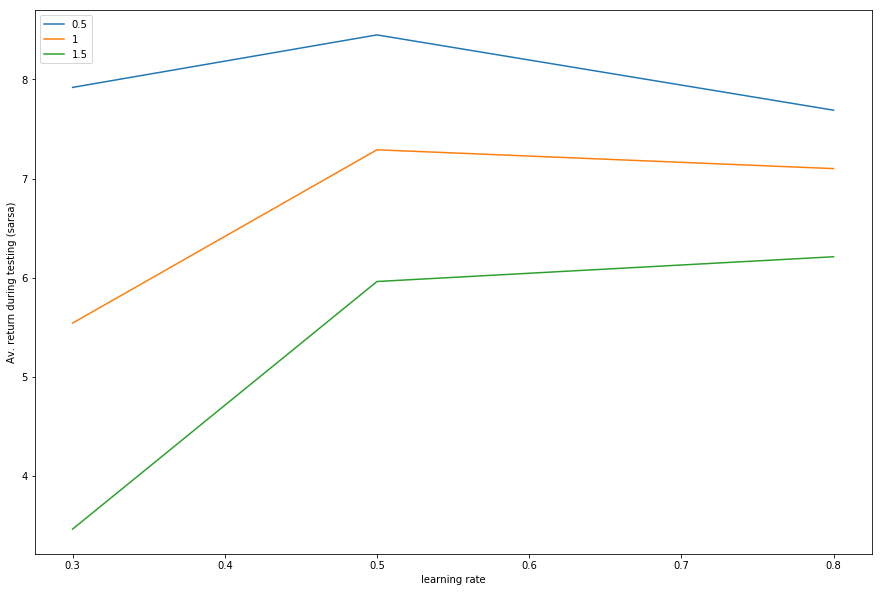

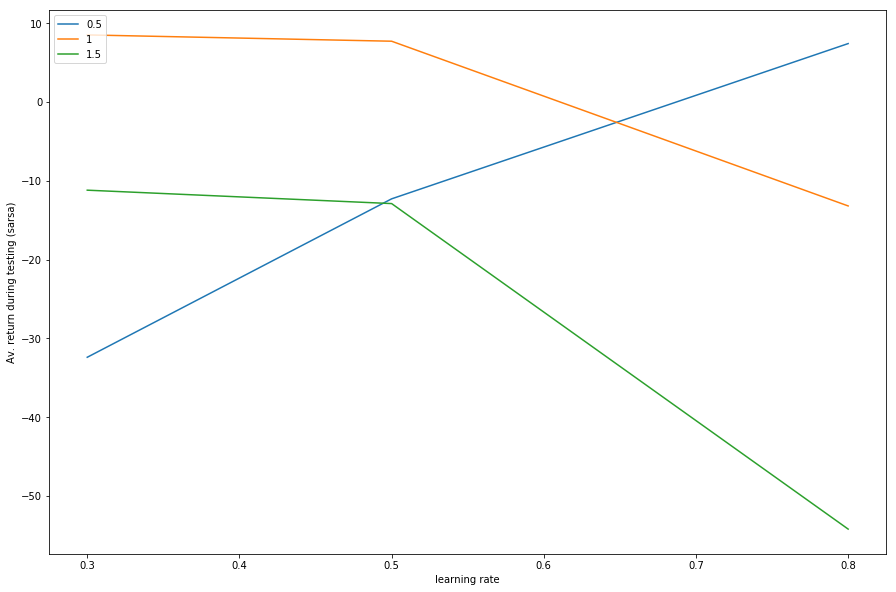

<Figure size 1080x720 with 0 Axes>

In [13]:
# plots for 'sarsa' training and test
plt.rcParams['figure.figsize'] = [15, 10]
plot_graph(learning_rates, agent_train_rewards, temperatures, 'learning rate',
           'Av. return during testing ('+agent+')', 'av_return_l_rate_testing_'+agent+'.png')
plot_graph(learning_rates, agent_test_rewards, temperatures, 'learning rate',
           'Av. return during testing ('+agent+')', 'av_return_l_rate_testing_'+agent+'.png')

q_learning | alpha 0.3, tau 0.50 | Run  0, Segment  0 | train reward  -499.70, test_reward -1055
q_learning | alpha 0.3, tau 0.50 | Run  0, Segment 10 | train reward  -159.10, test_reward -200
q_learning | alpha 0.3, tau 0.50 | Run  0, Segment 20 | train reward   -73.20, test_reward -200
q_learning | alpha 0.3, tau 0.50 | Run  0, Segment 30 | train reward   -57.80, test_reward 11
q_learning | alpha 0.3, tau 0.50 | Run  0, Segment 40 | train reward   -11.20, test_reward 15
q_learning | alpha 0.3, tau 0.50 | Run  0, Segment 50 | train reward    -0.90, test_reward 10
q_learning | alpha 0.3, tau 0.50 | Run  0, Segment 60 | train reward    -2.30, test_reward -200
q_learning | alpha 0.3, tau 0.50 | Run  0, Segment 70 | train reward    -2.00, test_reward 10
q_learning | alpha 0.3, tau 0.50 | Run  0, Segment 80 | train reward     8.20, test_reward 9
q_learning | alpha 0.3, tau 0.50 | Run  0, Segment 90 | train reward     7.10, test_reward -200
q_learning | alpha 0.3, tau 0.50 | Run  0, Segment

q_learning | alpha 0.3, tau 0.50 | Run  7, Segment 99 | train reward     7.70, test_reward 10
q_learning | alpha 0.3, tau 0.50 | Run  8, Segment  0 | train reward  -406.00, test_reward -677
q_learning | alpha 0.3, tau 0.50 | Run  8, Segment 10 | train reward  -151.00, test_reward -200
q_learning | alpha 0.3, tau 0.50 | Run  8, Segment 20 | train reward   -72.50, test_reward -200
q_learning | alpha 0.3, tau 0.50 | Run  8, Segment 30 | train reward   -29.60, test_reward -200
q_learning | alpha 0.3, tau 0.50 | Run  8, Segment 40 | train reward    -0.20, test_reward -200
q_learning | alpha 0.3, tau 0.50 | Run  8, Segment 50 | train reward     0.40, test_reward -200
q_learning | alpha 0.3, tau 0.50 | Run  8, Segment 60 | train reward     3.50, test_reward -200
q_learning | alpha 0.3, tau 0.50 | Run  8, Segment 70 | train reward     7.50, test_reward 9
q_learning | alpha 0.3, tau 0.50 | Run  8, Segment 80 | train reward     8.30, test_reward -200
q_learning | alpha 0.3, tau 0.50 | Run  8, Se

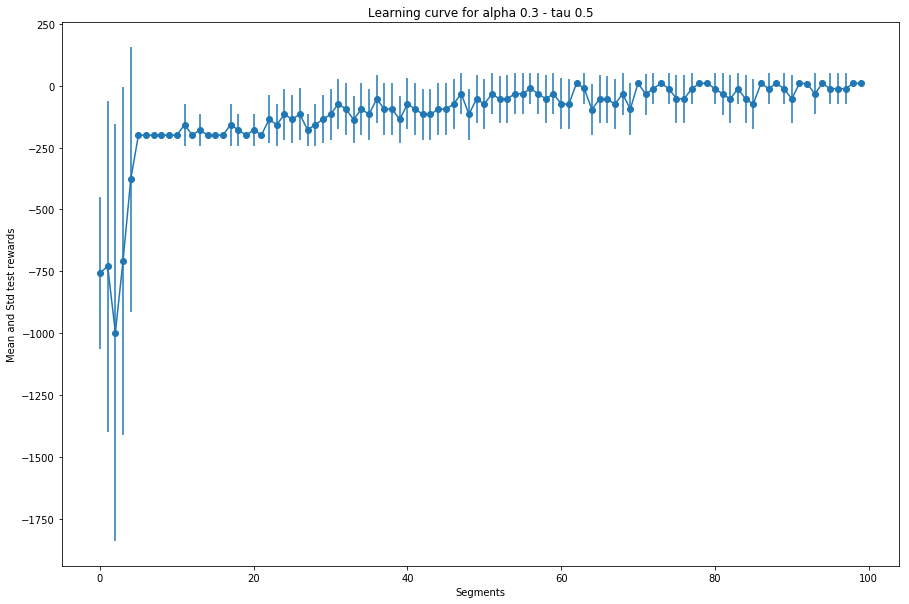

q_learning | alpha 0.5, tau 0.50 | Run  0, Segment  0 | train reward  -463.60, test_reward -839
q_learning | alpha 0.5, tau 0.50 | Run  0, Segment 10 | train reward  -155.00, test_reward -200
q_learning | alpha 0.5, tau 0.50 | Run  0, Segment 20 | train reward   -37.60, test_reward -200
q_learning | alpha 0.5, tau 0.50 | Run  0, Segment 30 | train reward     0.20, test_reward -200
q_learning | alpha 0.5, tau 0.50 | Run  0, Segment 40 | train reward     4.30, test_reward -200
q_learning | alpha 0.5, tau 0.50 | Run  0, Segment 50 | train reward     6.30, test_reward 6
q_learning | alpha 0.5, tau 0.50 | Run  0, Segment 60 | train reward     6.20, test_reward 6
q_learning | alpha 0.5, tau 0.50 | Run  0, Segment 70 | train reward     8.20, test_reward 8
q_learning | alpha 0.5, tau 0.50 | Run  0, Segment 80 | train reward     7.70, test_reward 8
q_learning | alpha 0.5, tau 0.50 | Run  0, Segment 90 | train reward     9.00, test_reward 7
q_learning | alpha 0.5, tau 0.50 | Run  0, Segment 99 |

q_learning | alpha 0.5, tau 0.50 | Run  8, Segment  0 | train reward  -537.50, test_reward -794
q_learning | alpha 0.5, tau 0.50 | Run  8, Segment 10 | train reward  -141.20, test_reward -200
q_learning | alpha 0.5, tau 0.50 | Run  8, Segment 20 | train reward   -61.70, test_reward 13
q_learning | alpha 0.5, tau 0.50 | Run  8, Segment 30 | train reward    -2.60, test_reward 8
q_learning | alpha 0.5, tau 0.50 | Run  8, Segment 40 | train reward    -0.60, test_reward 4
q_learning | alpha 0.5, tau 0.50 | Run  8, Segment 50 | train reward     3.50, test_reward 6
q_learning | alpha 0.5, tau 0.50 | Run  8, Segment 60 | train reward     5.20, test_reward -200
q_learning | alpha 0.5, tau 0.50 | Run  8, Segment 70 | train reward     8.20, test_reward 7
q_learning | alpha 0.5, tau 0.50 | Run  8, Segment 80 | train reward     7.40, test_reward 9
q_learning | alpha 0.5, tau 0.50 | Run  8, Segment 90 | train reward     5.60, test_reward 10
q_learning | alpha 0.5, tau 0.50 | Run  8, Segment 99 | tra

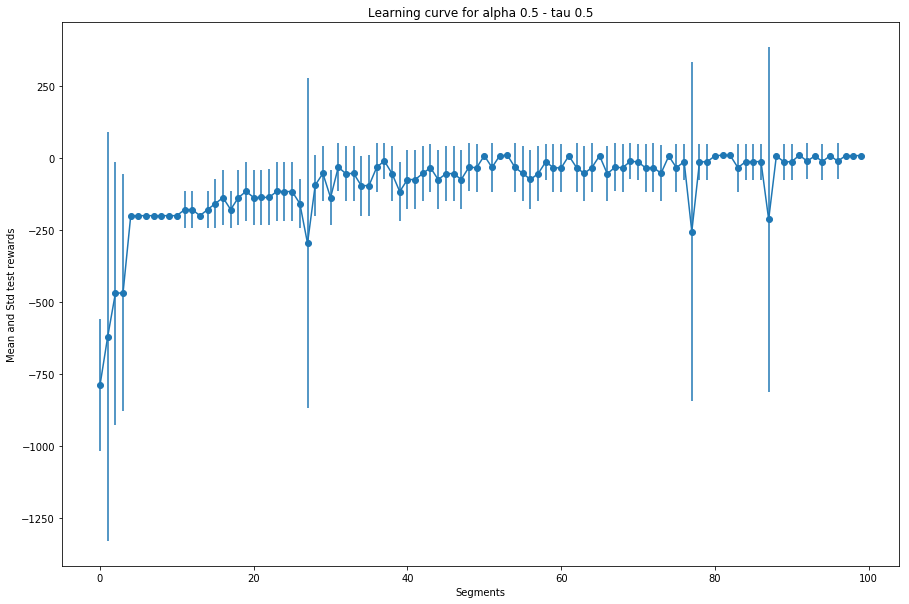

q_learning | alpha 0.8, tau 0.50 | Run  0, Segment  0 | train reward  -500.80, test_reward -875
q_learning | alpha 0.8, tau 0.50 | Run  0, Segment 10 | train reward   -65.60, test_reward -200
q_learning | alpha 0.8, tau 0.50 | Run  0, Segment 20 | train reward    -5.20, test_reward 8
q_learning | alpha 0.8, tau 0.50 | Run  0, Segment 30 | train reward     6.20, test_reward 9
q_learning | alpha 0.8, tau 0.50 | Run  0, Segment 40 | train reward     6.40, test_reward -200
q_learning | alpha 0.8, tau 0.50 | Run  0, Segment 50 | train reward     8.20, test_reward 9
q_learning | alpha 0.8, tau 0.50 | Run  0, Segment 60 | train reward     4.90, test_reward 11
q_learning | alpha 0.8, tau 0.50 | Run  0, Segment 70 | train reward     7.50, test_reward 8
q_learning | alpha 0.8, tau 0.50 | Run  0, Segment 80 | train reward     8.10, test_reward 5
q_learning | alpha 0.8, tau 0.50 | Run  0, Segment 90 | train reward     7.70, test_reward 8
q_learning | alpha 0.8, tau 0.50 | Run  0, Segment 99 | trai

q_learning | alpha 0.8, tau 0.50 | Run  8, Segment 10 | train reward   -67.90, test_reward -200
q_learning | alpha 0.8, tau 0.50 | Run  8, Segment 20 | train reward   -18.20, test_reward -200
q_learning | alpha 0.8, tau 0.50 | Run  8, Segment 30 | train reward    -8.00, test_reward 9
q_learning | alpha 0.8, tau 0.50 | Run  8, Segment 40 | train reward     4.80, test_reward 9
q_learning | alpha 0.8, tau 0.50 | Run  8, Segment 50 | train reward     5.60, test_reward 6
q_learning | alpha 0.8, tau 0.50 | Run  8, Segment 60 | train reward     7.40, test_reward 8
q_learning | alpha 0.8, tau 0.50 | Run  8, Segment 70 | train reward     9.10, test_reward 10
q_learning | alpha 0.8, tau 0.50 | Run  8, Segment 80 | train reward     6.70, test_reward 8
q_learning | alpha 0.8, tau 0.50 | Run  8, Segment 90 | train reward     5.40, test_reward 6
q_learning | alpha 0.8, tau 0.50 | Run  8, Segment 99 | train reward     7.20, test_reward 3
q_learning | alpha 0.8, tau 0.50 | Run  9, Segment  0 | train r

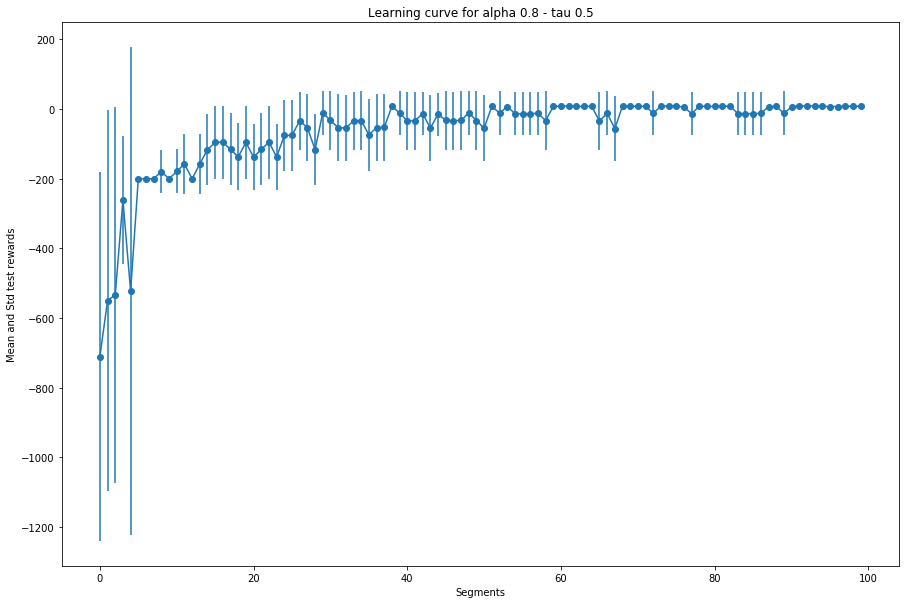

q_learning | alpha 0.3, tau 1.00 | Run  0, Segment  0 | train reward  -456.50, test_reward -911
q_learning | alpha 0.3, tau 1.00 | Run  0, Segment 10 | train reward  -235.60, test_reward -200
q_learning | alpha 0.3, tau 1.00 | Run  0, Segment 20 | train reward  -133.10, test_reward -200
q_learning | alpha 0.3, tau 1.00 | Run  0, Segment 30 | train reward   -52.90, test_reward 11
q_learning | alpha 0.3, tau 1.00 | Run  0, Segment 40 | train reward    -9.10, test_reward 13
q_learning | alpha 0.3, tau 1.00 | Run  0, Segment 50 | train reward   -19.40, test_reward 12
q_learning | alpha 0.3, tau 1.00 | Run  0, Segment 60 | train reward   -10.60, test_reward 10
q_learning | alpha 0.3, tau 1.00 | Run  0, Segment 70 | train reward     0.10, test_reward -200
q_learning | alpha 0.3, tau 1.00 | Run  0, Segment 80 | train reward     6.40, test_reward 9
q_learning | alpha 0.3, tau 1.00 | Run  0, Segment 90 | train reward     5.60, test_reward 10
q_learning | alpha 0.3, tau 1.00 | Run  0, Segment 99

q_learning | alpha 0.3, tau 1.00 | Run  7, Segment 99 | train reward     3.60, test_reward 7
q_learning | alpha 0.3, tau 1.00 | Run  8, Segment  0 | train reward  -448.80, test_reward -200
q_learning | alpha 0.3, tau 1.00 | Run  8, Segment 10 | train reward  -227.50, test_reward -200
q_learning | alpha 0.3, tau 1.00 | Run  8, Segment 20 | train reward  -135.10, test_reward -200
q_learning | alpha 0.3, tau 1.00 | Run  8, Segment 30 | train reward   -67.90, test_reward -200
q_learning | alpha 0.3, tau 1.00 | Run  8, Segment 40 | train reward   -15.50, test_reward 14
q_learning | alpha 0.3, tau 1.00 | Run  8, Segment 50 | train reward    -1.30, test_reward -200
q_learning | alpha 0.3, tau 1.00 | Run  8, Segment 60 | train reward     6.90, test_reward 10
q_learning | alpha 0.3, tau 1.00 | Run  8, Segment 70 | train reward     0.00, test_reward -200
q_learning | alpha 0.3, tau 1.00 | Run  8, Segment 80 | train reward     0.20, test_reward 6
q_learning | alpha 0.3, tau 1.00 | Run  8, Segment

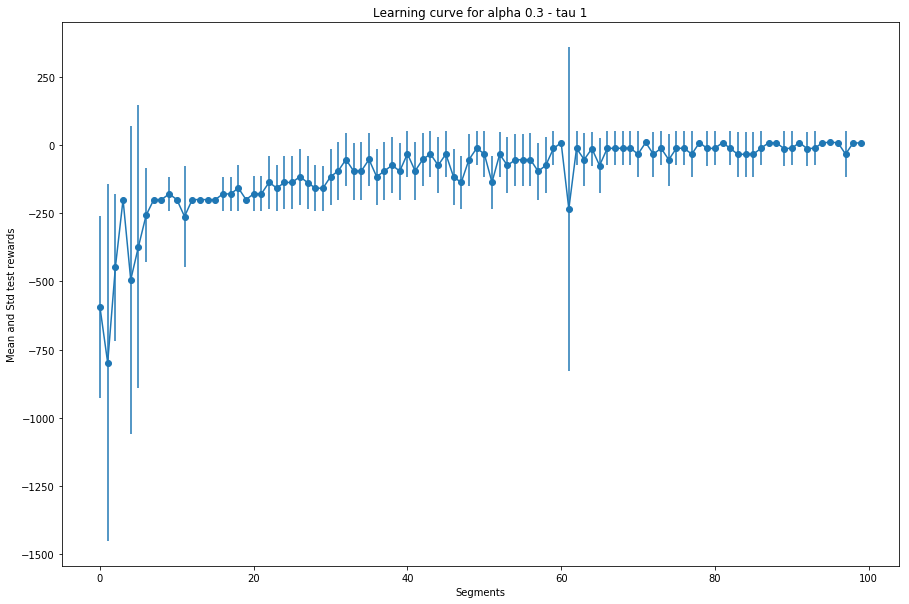

q_learning | alpha 0.5, tau 1.00 | Run  0, Segment  0 | train reward  -518.60, test_reward -1874
q_learning | alpha 0.5, tau 1.00 | Run  0, Segment 10 | train reward  -147.20, test_reward -200
q_learning | alpha 0.5, tau 1.00 | Run  0, Segment 20 | train reward   -90.10, test_reward -200
q_learning | alpha 0.5, tau 1.00 | Run  0, Segment 30 | train reward   -31.30, test_reward 11
q_learning | alpha 0.5, tau 1.00 | Run  0, Segment 40 | train reward    -8.30, test_reward 5
q_learning | alpha 0.5, tau 1.00 | Run  0, Segment 50 | train reward     7.50, test_reward -200
q_learning | alpha 0.5, tau 1.00 | Run  0, Segment 60 | train reward     8.20, test_reward -200
q_learning | alpha 0.5, tau 1.00 | Run  0, Segment 70 | train reward     9.00, test_reward 6
q_learning | alpha 0.5, tau 1.00 | Run  0, Segment 80 | train reward     6.70, test_reward 13
q_learning | alpha 0.5, tau 1.00 | Run  0, Segment 90 | train reward     7.10, test_reward 8
q_learning | alpha 0.5, tau 1.00 | Run  0, Segment 9

q_learning | alpha 0.5, tau 1.00 | Run  7, Segment 99 | train reward     5.80, test_reward 9
q_learning | alpha 0.5, tau 1.00 | Run  8, Segment  0 | train reward  -473.70, test_reward -533
q_learning | alpha 0.5, tau 1.00 | Run  8, Segment 10 | train reward  -121.90, test_reward -200
q_learning | alpha 0.5, tau 1.00 | Run  8, Segment 20 | train reward  -100.70, test_reward -200
q_learning | alpha 0.5, tau 1.00 | Run  8, Segment 30 | train reward   -20.20, test_reward 9
q_learning | alpha 0.5, tau 1.00 | Run  8, Segment 40 | train reward    -8.50, test_reward 6
q_learning | alpha 0.5, tau 1.00 | Run  8, Segment 50 | train reward     6.80, test_reward 13
q_learning | alpha 0.5, tau 1.00 | Run  8, Segment 60 | train reward     3.70, test_reward 13
q_learning | alpha 0.5, tau 1.00 | Run  8, Segment 70 | train reward     8.80, test_reward 4
q_learning | alpha 0.5, tau 1.00 | Run  8, Segment 80 | train reward     7.90, test_reward 5
q_learning | alpha 0.5, tau 1.00 | Run  8, Segment 90 | tra

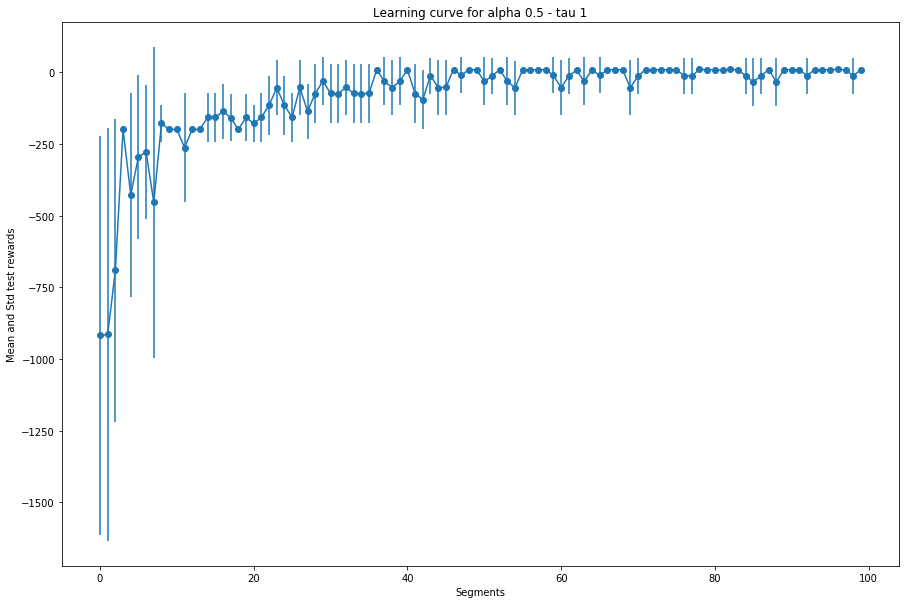

q_learning | alpha 0.8, tau 1.00 | Run  0, Segment  0 | train reward  -456.40, test_reward -785
q_learning | alpha 0.8, tau 1.00 | Run  0, Segment 10 | train reward  -128.50, test_reward -200
q_learning | alpha 0.8, tau 1.00 | Run  0, Segment 20 | train reward   -69.50, test_reward -200
q_learning | alpha 0.8, tau 1.00 | Run  0, Segment 30 | train reward   -22.10, test_reward -200
q_learning | alpha 0.8, tau 1.00 | Run  0, Segment 40 | train reward    -0.70, test_reward -200
q_learning | alpha 0.8, tau 1.00 | Run  0, Segment 50 | train reward     2.70, test_reward 3
q_learning | alpha 0.8, tau 1.00 | Run  0, Segment 60 | train reward     7.10, test_reward 6
q_learning | alpha 0.8, tau 1.00 | Run  0, Segment 70 | train reward     7.90, test_reward 5
q_learning | alpha 0.8, tau 1.00 | Run  0, Segment 80 | train reward     8.60, test_reward 7
q_learning | alpha 0.8, tau 1.00 | Run  0, Segment 90 | train reward     6.30, test_reward 6
q_learning | alpha 0.8, tau 1.00 | Run  0, Segment 99 |

q_learning | alpha 0.8, tau 1.00 | Run  7, Segment 99 | train reward     6.10, test_reward 7
q_learning | alpha 0.8, tau 1.00 | Run  8, Segment  0 | train reward  -457.40, test_reward -803
q_learning | alpha 0.8, tau 1.00 | Run  8, Segment 10 | train reward   -94.50, test_reward -200
q_learning | alpha 0.8, tau 1.00 | Run  8, Segment 20 | train reward   -64.60, test_reward -200
q_learning | alpha 0.8, tau 1.00 | Run  8, Segment 30 | train reward   -16.00, test_reward 11
q_learning | alpha 0.8, tau 1.00 | Run  8, Segment 40 | train reward     3.10, test_reward 7
q_learning | alpha 0.8, tau 1.00 | Run  8, Segment 50 | train reward     7.40, test_reward -200
q_learning | alpha 0.8, tau 1.00 | Run  8, Segment 60 | train reward     5.90, test_reward 8
q_learning | alpha 0.8, tau 1.00 | Run  8, Segment 70 | train reward     6.80, test_reward 8
q_learning | alpha 0.8, tau 1.00 | Run  8, Segment 80 | train reward     7.00, test_reward 6
q_learning | alpha 0.8, tau 1.00 | Run  8, Segment 90 | t

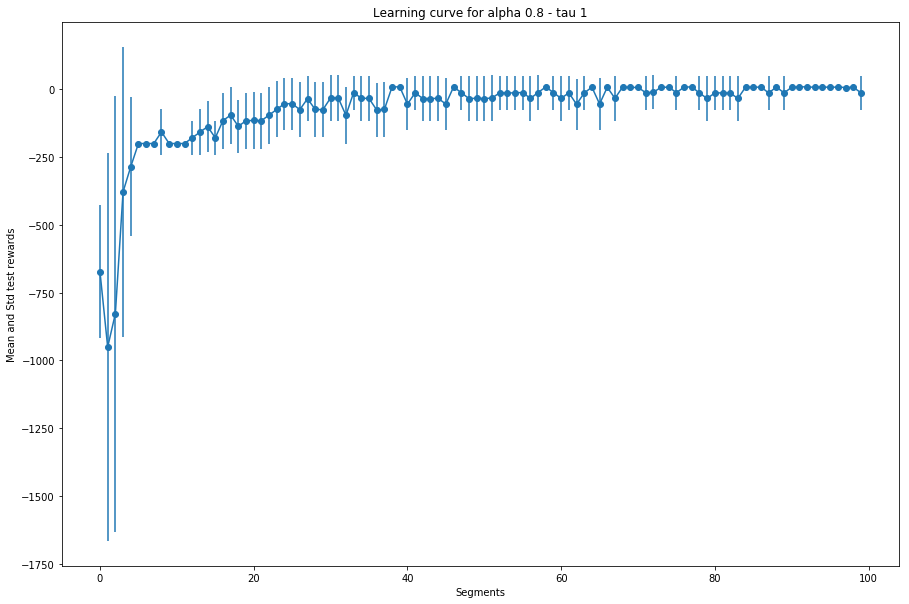

q_learning | alpha 0.3, tau 1.50 | Run  0, Segment  0 | train reward  -510.50, test_reward -200
q_learning | alpha 0.3, tau 1.50 | Run  0, Segment 10 | train reward  -289.10, test_reward -200
q_learning | alpha 0.3, tau 1.50 | Run  0, Segment 20 | train reward  -144.20, test_reward -200
q_learning | alpha 0.3, tau 1.50 | Run  0, Segment 30 | train reward  -146.00, test_reward 13
q_learning | alpha 0.3, tau 1.50 | Run  0, Segment 40 | train reward   -39.80, test_reward -200
q_learning | alpha 0.3, tau 1.50 | Run  0, Segment 50 | train reward   -12.30, test_reward 5
q_learning | alpha 0.3, tau 1.50 | Run  0, Segment 60 | train reward   -18.90, test_reward 8
q_learning | alpha 0.3, tau 1.50 | Run  0, Segment 70 | train reward   -23.80, test_reward 9
q_learning | alpha 0.3, tau 1.50 | Run  0, Segment 80 | train reward     2.60, test_reward 12
q_learning | alpha 0.3, tau 1.50 | Run  0, Segment 90 | train reward     3.80, test_reward 8
q_learning | alpha 0.3, tau 1.50 | Run  0, Segment 99 | 

q_learning | alpha 0.3, tau 1.50 | Run  7, Segment 99 | train reward     2.70, test_reward 4
q_learning | alpha 0.3, tau 1.50 | Run  8, Segment  0 | train reward  -504.30, test_reward -929
q_learning | alpha 0.3, tau 1.50 | Run  8, Segment 10 | train reward  -249.00, test_reward -200
q_learning | alpha 0.3, tau 1.50 | Run  8, Segment 20 | train reward  -169.50, test_reward -200
q_learning | alpha 0.3, tau 1.50 | Run  8, Segment 30 | train reward  -107.70, test_reward 12
q_learning | alpha 0.3, tau 1.50 | Run  8, Segment 40 | train reward   -54.30, test_reward 9
q_learning | alpha 0.3, tau 1.50 | Run  8, Segment 50 | train reward   -28.90, test_reward 9
q_learning | alpha 0.3, tau 1.50 | Run  8, Segment 60 | train reward     1.80, test_reward 5
q_learning | alpha 0.3, tau 1.50 | Run  8, Segment 70 | train reward     3.70, test_reward 11
q_learning | alpha 0.3, tau 1.50 | Run  8, Segment 80 | train reward     0.90, test_reward 13
q_learning | alpha 0.3, tau 1.50 | Run  8, Segment 90 | tr

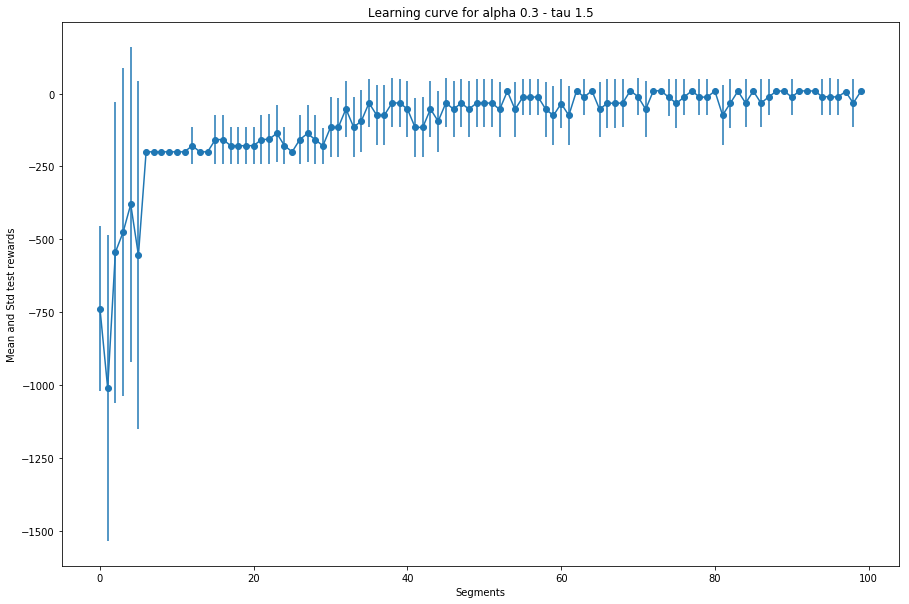

q_learning | alpha 0.5, tau 1.50 | Run  0, Segment  0 | train reward  -470.40, test_reward -803
q_learning | alpha 0.5, tau 1.50 | Run  0, Segment 10 | train reward  -151.60, test_reward -200
q_learning | alpha 0.5, tau 1.50 | Run  0, Segment 20 | train reward  -114.30, test_reward 11
q_learning | alpha 0.5, tau 1.50 | Run  0, Segment 30 | train reward   -41.80, test_reward 8
q_learning | alpha 0.5, tau 1.50 | Run  0, Segment 40 | train reward     0.10, test_reward 8
q_learning | alpha 0.5, tau 1.50 | Run  0, Segment 50 | train reward    -2.90, test_reward -200
q_learning | alpha 0.5, tau 1.50 | Run  0, Segment 60 | train reward     2.70, test_reward -200
q_learning | alpha 0.5, tau 1.50 | Run  0, Segment 70 | train reward     5.80, test_reward 12
q_learning | alpha 0.5, tau 1.50 | Run  0, Segment 80 | train reward     5.30, test_reward 8
q_learning | alpha 0.5, tau 1.50 | Run  0, Segment 90 | train reward     4.90, test_reward 9
q_learning | alpha 0.5, tau 1.50 | Run  0, Segment 99 | 

q_learning | alpha 0.5, tau 1.50 | Run  7, Segment 99 | train reward     1.90, test_reward 12
q_learning | alpha 0.5, tau 1.50 | Run  8, Segment  0 | train reward  -484.40, test_reward -200
q_learning | alpha 0.5, tau 1.50 | Run  8, Segment 10 | train reward  -183.70, test_reward -200
q_learning | alpha 0.5, tau 1.50 | Run  8, Segment 20 | train reward   -67.00, test_reward -200
q_learning | alpha 0.5, tau 1.50 | Run  8, Segment 30 | train reward   -56.20, test_reward 12
q_learning | alpha 0.5, tau 1.50 | Run  8, Segment 40 | train reward   -13.50, test_reward 8
q_learning | alpha 0.5, tau 1.50 | Run  8, Segment 50 | train reward     6.90, test_reward 10
q_learning | alpha 0.5, tau 1.50 | Run  8, Segment 60 | train reward     5.30, test_reward 8
q_learning | alpha 0.5, tau 1.50 | Run  8, Segment 70 | train reward     8.80, test_reward -200
q_learning | alpha 0.5, tau 1.50 | Run  8, Segment 80 | train reward     5.40, test_reward 7
q_learning | alpha 0.5, tau 1.50 | Run  8, Segment 90 |

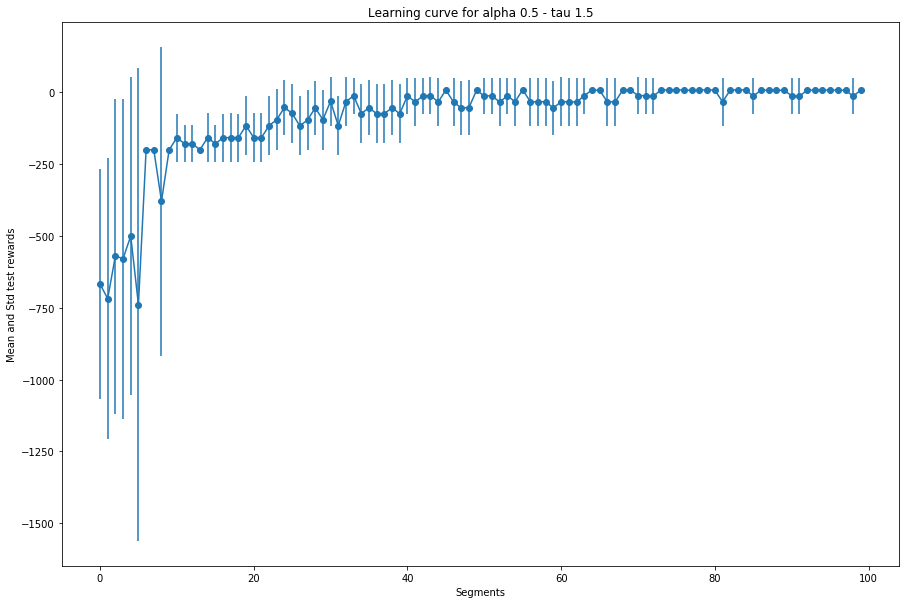

q_learning | alpha 0.8, tau 1.50 | Run  0, Segment  0 | train reward  -470.00, test_reward -704
q_learning | alpha 0.8, tau 1.50 | Run  0, Segment 10 | train reward  -145.30, test_reward -200
q_learning | alpha 0.8, tau 1.50 | Run  0, Segment 20 | train reward   -56.80, test_reward -200
q_learning | alpha 0.8, tau 1.50 | Run  0, Segment 30 | train reward   -11.60, test_reward 11
q_learning | alpha 0.8, tau 1.50 | Run  0, Segment 40 | train reward    -0.20, test_reward 11
q_learning | alpha 0.8, tau 1.50 | Run  0, Segment 50 | train reward     0.80, test_reward 9
q_learning | alpha 0.8, tau 1.50 | Run  0, Segment 60 | train reward     0.60, test_reward 6
q_learning | alpha 0.8, tau 1.50 | Run  0, Segment 70 | train reward     8.10, test_reward -200
q_learning | alpha 0.8, tau 1.50 | Run  0, Segment 80 | train reward     1.70, test_reward 7
q_learning | alpha 0.8, tau 1.50 | Run  0, Segment 90 | train reward     3.80, test_reward 6
q_learning | alpha 0.8, tau 1.50 | Run  0, Segment 99 | 

q_learning | alpha 0.8, tau 1.50 | Run  8, Segment  0 | train reward  -438.50, test_reward -200
q_learning | alpha 0.8, tau 1.50 | Run  8, Segment 10 | train reward  -130.50, test_reward -200
q_learning | alpha 0.8, tau 1.50 | Run  8, Segment 20 | train reward   -59.70, test_reward 8
q_learning | alpha 0.8, tau 1.50 | Run  8, Segment 30 | train reward    -5.20, test_reward -200
q_learning | alpha 0.8, tau 1.50 | Run  8, Segment 40 | train reward     6.20, test_reward 3
q_learning | alpha 0.8, tau 1.50 | Run  8, Segment 50 | train reward     1.80, test_reward 5
q_learning | alpha 0.8, tau 1.50 | Run  8, Segment 60 | train reward     4.50, test_reward 11
q_learning | alpha 0.8, tau 1.50 | Run  8, Segment 70 | train reward     2.70, test_reward 9
q_learning | alpha 0.8, tau 1.50 | Run  8, Segment 80 | train reward     4.90, test_reward 11
q_learning | alpha 0.8, tau 1.50 | Run  8, Segment 90 | train reward     4.00, test_reward 7
q_learning | alpha 0.8, tau 1.50 | Run  8, Segment 99 | tra

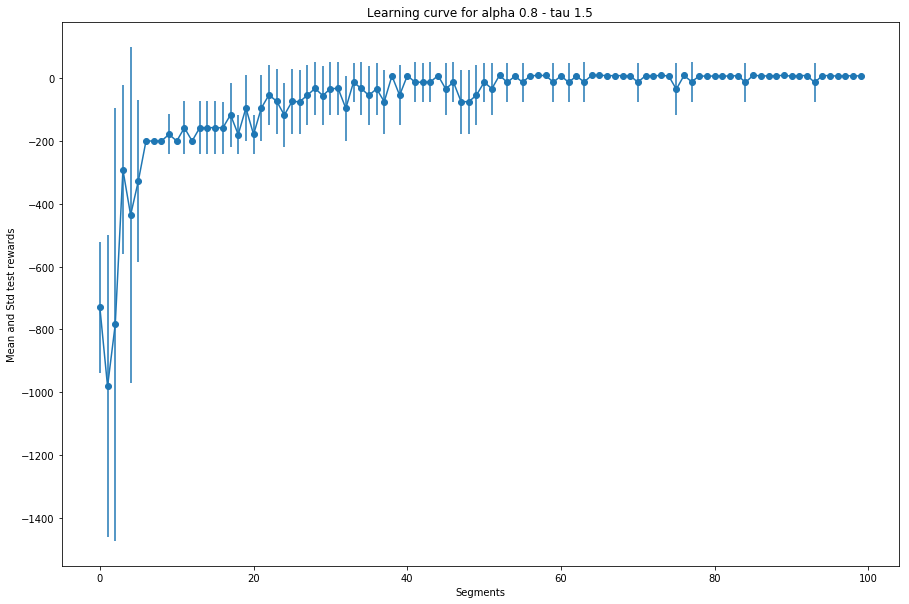

In [6]:
agents = ['q_learning']
for agent in agents:
    agent_train_rewards = np.zeros(shape=(len(temperatures), len(learning_rates)))
    agent_test_rewards = np.zeros_like(agent_train_rewards)
    for temp in temperatures:
        for learning_rate in learning_rates:
            agent_object = TaxiEnv(agent, learning_rate, temp, env, gamma=0.9)
            train_rewards, test_rewards, avg_test, std_test = agent_object.train(print_trace=True)
            agent_train_rewards[temperatures.index(temp)][learning_rates.index(learning_rate)] = train_rewards
            agent_test_rewards[temperatures.index(temp)][learning_rates.index(learning_rate)] = test_rewards
            
            plt.rcParams['figure.figsize'] = [15, 10]
            plot_error(np.arange(100), avg_test, std_test, learning_rate, temp)

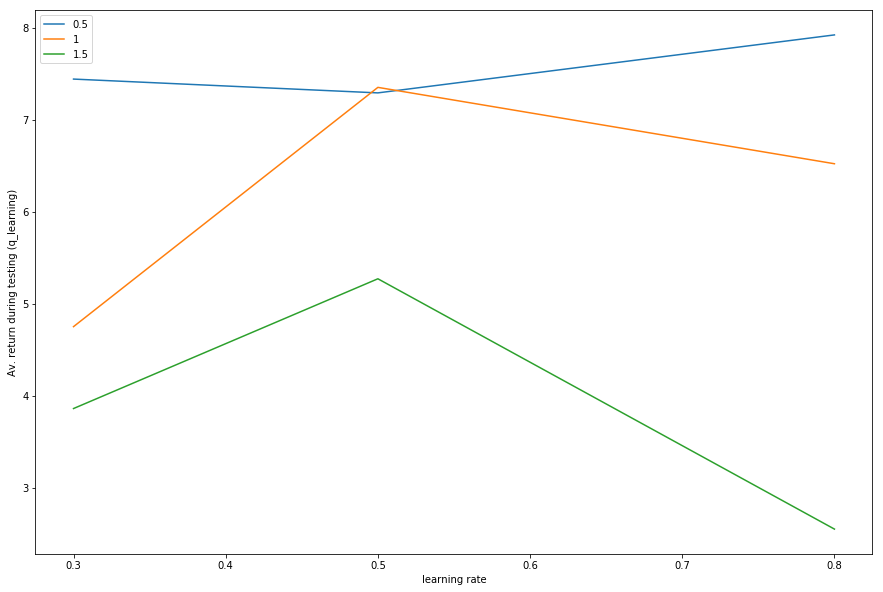

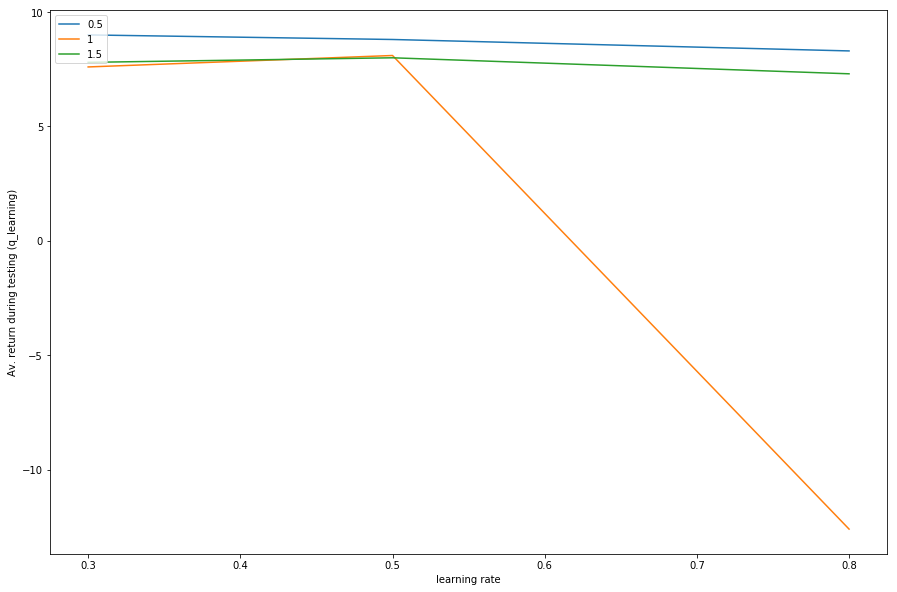

<Figure size 1080x720 with 0 Axes>

In [11]:
# plots for 'q_learning' training and test
plt.rcParams['figure.figsize'] = [15, 10]
    
plot_graph(learning_rates, agent_train_rewards, temperatures, 'learning rate',
           'Av. return during testing ('+agent+')', 'av_return_l_rate_testing_'+agent+'.png')
plot_graph(learning_rates, agent_test_rewards, temperatures, 'learning rate',
           'Av. return during testing ('+agent+')', 'av_return_l_rate_testing_'+agent+'.png')

expected_sarsa | alpha 0.3, tau 0.50 | Run  0, Segment  0 | train reward  -526.00, test_reward -875
expected_sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 10 | train reward  -221.90, test_reward -200
expected_sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 20 | train reward  -181.20, test_reward -200
expected_sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 30 | train reward   -78.30, test_reward -200
expected_sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 40 | train reward  -130.40, test_reward -200
expected_sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 50 | train reward  -146.30, test_reward -200
expected_sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 60 | train reward   -53.40, test_reward -200
expected_sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 70 | train reward   -53.60, test_reward 8
expected_sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 80 | train reward   -78.50, test_reward -200
expected_sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 90 | train reward   -67.40, test_reward 11
expec

expected_sarsa | alpha 0.3, tau 0.50 | Run  7, Segment 60 | train reward  -115.20, test_reward -200
expected_sarsa | alpha 0.3, tau 0.50 | Run  7, Segment 70 | train reward   -81.80, test_reward -200
expected_sarsa | alpha 0.3, tau 0.50 | Run  7, Segment 80 | train reward   -66.40, test_reward -200
expected_sarsa | alpha 0.3, tau 0.50 | Run  7, Segment 90 | train reward   -99.20, test_reward -200
expected_sarsa | alpha 0.3, tau 0.50 | Run  7, Segment 99 | train reward   -57.40, test_reward -200
expected_sarsa | alpha 0.3, tau 0.50 | Run  8, Segment  0 | train reward  -464.60, test_reward -713
expected_sarsa | alpha 0.3, tau 0.50 | Run  8, Segment 10 | train reward  -224.60, test_reward -200
expected_sarsa | alpha 0.3, tau 0.50 | Run  8, Segment 20 | train reward  -169.30, test_reward -200
expected_sarsa | alpha 0.3, tau 0.50 | Run  8, Segment 30 | train reward  -183.40, test_reward -200
expected_sarsa | alpha 0.3, tau 0.50 | Run  8, Segment 40 | train reward  -103.00, test_reward -200


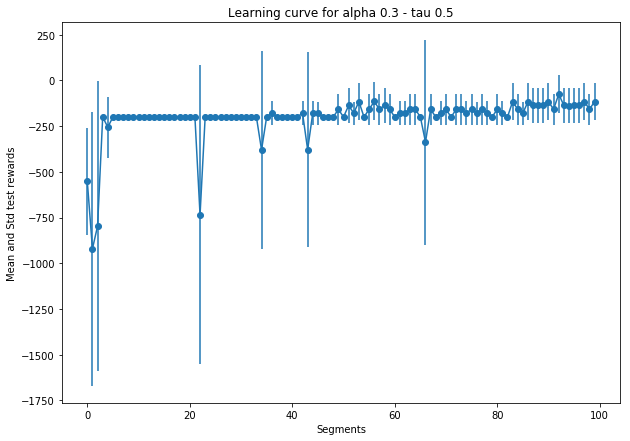

expected_sarsa | alpha 0.5, tau 0.50 | Run  0, Segment  0 | train reward  -512.30, test_reward -200
expected_sarsa | alpha 0.5, tau 0.50 | Run  0, Segment 10 | train reward  -197.40, test_reward -200
expected_sarsa | alpha 0.5, tau 0.50 | Run  0, Segment 20 | train reward  -177.20, test_reward -200
expected_sarsa | alpha 0.5, tau 0.50 | Run  0, Segment 30 | train reward   -93.10, test_reward 15
expected_sarsa | alpha 0.5, tau 0.50 | Run  0, Segment 40 | train reward  -110.00, test_reward -200
expected_sarsa | alpha 0.5, tau 0.50 | Run  0, Segment 50 | train reward  -103.10, test_reward -200
expected_sarsa | alpha 0.5, tau 0.50 | Run  0, Segment 60 | train reward   -50.20, test_reward -200
expected_sarsa | alpha 0.5, tau 0.50 | Run  0, Segment 70 | train reward   -34.20, test_reward -200
expected_sarsa | alpha 0.5, tau 0.50 | Run  0, Segment 80 | train reward   -85.10, test_reward -200
expected_sarsa | alpha 0.5, tau 0.50 | Run  0, Segment 90 | train reward  -106.60, test_reward 6
expec

expected_sarsa | alpha 0.5, tau 0.50 | Run  7, Segment 60 | train reward  -116.90, test_reward -200
expected_sarsa | alpha 0.5, tau 0.50 | Run  7, Segment 70 | train reward   -73.70, test_reward 13
expected_sarsa | alpha 0.5, tau 0.50 | Run  7, Segment 80 | train reward   -39.10, test_reward 14
expected_sarsa | alpha 0.5, tau 0.50 | Run  7, Segment 90 | train reward   -65.60, test_reward 12
expected_sarsa | alpha 0.5, tau 0.50 | Run  7, Segment 99 | train reward   -72.10, test_reward 11
expected_sarsa | alpha 0.5, tau 0.50 | Run  8, Segment  0 | train reward  -471.80, test_reward -1982
expected_sarsa | alpha 0.5, tau 0.50 | Run  8, Segment 10 | train reward  -206.20, test_reward -200
expected_sarsa | alpha 0.5, tau 0.50 | Run  8, Segment 20 | train reward   -91.50, test_reward -200
expected_sarsa | alpha 0.5, tau 0.50 | Run  8, Segment 30 | train reward   -94.90, test_reward -200
expected_sarsa | alpha 0.5, tau 0.50 | Run  8, Segment 40 | train reward  -115.40, test_reward -200
expecte

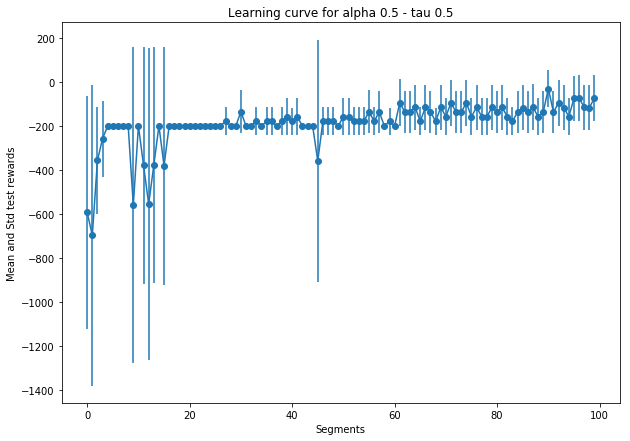

expected_sarsa | alpha 0.8, tau 0.50 | Run  0, Segment  0 | train reward  -523.10, test_reward -794
expected_sarsa | alpha 0.8, tau 0.50 | Run  0, Segment 10 | train reward  -160.10, test_reward -200
expected_sarsa | alpha 0.8, tau 0.50 | Run  0, Segment 20 | train reward   -84.70, test_reward 11
expected_sarsa | alpha 0.8, tau 0.50 | Run  0, Segment 30 | train reward  -172.60, test_reward -200
expected_sarsa | alpha 0.8, tau 0.50 | Run  0, Segment 40 | train reward  -129.10, test_reward 11
expected_sarsa | alpha 0.8, tau 0.50 | Run  0, Segment 50 | train reward  -121.70, test_reward -200
expected_sarsa | alpha 0.8, tau 0.50 | Run  0, Segment 60 | train reward  -159.50, test_reward -200
expected_sarsa | alpha 0.8, tau 0.50 | Run  0, Segment 70 | train reward  -176.30, test_reward -200
expected_sarsa | alpha 0.8, tau 0.50 | Run  0, Segment 80 | train reward  -155.30, test_reward -200
expected_sarsa | alpha 0.8, tau 0.50 | Run  0, Segment 90 | train reward  -112.00, test_reward -200
expe

expected_sarsa | alpha 0.8, tau 0.50 | Run  7, Segment 60 | train reward  -141.40, test_reward -200
expected_sarsa | alpha 0.8, tau 0.50 | Run  7, Segment 70 | train reward  -146.80, test_reward -200
expected_sarsa | alpha 0.8, tau 0.50 | Run  7, Segment 80 | train reward  -131.90, test_reward -200
expected_sarsa | alpha 0.8, tau 0.50 | Run  7, Segment 90 | train reward  -137.60, test_reward -200
expected_sarsa | alpha 0.8, tau 0.50 | Run  7, Segment 99 | train reward  -172.70, test_reward 7
expected_sarsa | alpha 0.8, tau 0.50 | Run  8, Segment  0 | train reward  -524.10, test_reward -200
expected_sarsa | alpha 0.8, tau 0.50 | Run  8, Segment 10 | train reward  -114.90, test_reward -200
expected_sarsa | alpha 0.8, tau 0.50 | Run  8, Segment 20 | train reward   -65.00, test_reward -200
expected_sarsa | alpha 0.8, tau 0.50 | Run  8, Segment 30 | train reward   -88.40, test_reward -200
expected_sarsa | alpha 0.8, tau 0.50 | Run  8, Segment 40 | train reward  -148.50, test_reward -200
exp

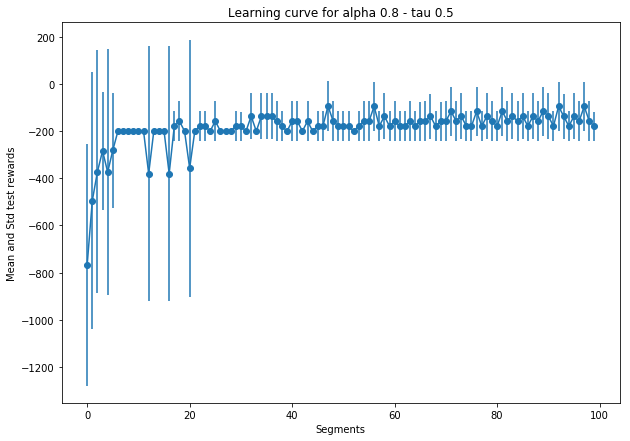

expected_sarsa | alpha 0.3, tau 1.00 | Run  0, Segment  0 | train reward  -478.90, test_reward -803
expected_sarsa | alpha 0.3, tau 1.00 | Run  0, Segment 10 | train reward  -270.50, test_reward -200
expected_sarsa | alpha 0.3, tau 1.00 | Run  0, Segment 20 | train reward  -204.90, test_reward -200
expected_sarsa | alpha 0.3, tau 1.00 | Run  0, Segment 30 | train reward  -168.70, test_reward -200
expected_sarsa | alpha 0.3, tau 1.00 | Run  0, Segment 40 | train reward  -193.70, test_reward -200
expected_sarsa | alpha 0.3, tau 1.00 | Run  0, Segment 50 | train reward  -105.50, test_reward -200
expected_sarsa | alpha 0.3, tau 1.00 | Run  0, Segment 60 | train reward  -169.30, test_reward -200
expected_sarsa | alpha 0.3, tau 1.00 | Run  0, Segment 70 | train reward  -160.60, test_reward -200
expected_sarsa | alpha 0.3, tau 1.00 | Run  0, Segment 80 | train reward   -89.40, test_reward -200
expected_sarsa | alpha 0.3, tau 1.00 | Run  0, Segment 90 | train reward  -124.70, test_reward -200


expected_sarsa | alpha 0.3, tau 1.00 | Run  7, Segment 50 | train reward  -100.90, test_reward -200
expected_sarsa | alpha 0.3, tau 1.00 | Run  7, Segment 60 | train reward  -156.50, test_reward -200
expected_sarsa | alpha 0.3, tau 1.00 | Run  7, Segment 70 | train reward  -130.30, test_reward 9
expected_sarsa | alpha 0.3, tau 1.00 | Run  7, Segment 80 | train reward  -138.90, test_reward -200
expected_sarsa | alpha 0.3, tau 1.00 | Run  7, Segment 90 | train reward  -122.30, test_reward -200
expected_sarsa | alpha 0.3, tau 1.00 | Run  7, Segment 99 | train reward  -140.50, test_reward -200
expected_sarsa | alpha 0.3, tau 1.00 | Run  8, Segment  0 | train reward  -437.90, test_reward -1163
expected_sarsa | alpha 0.3, tau 1.00 | Run  8, Segment 10 | train reward  -275.70, test_reward -200
expected_sarsa | alpha 0.3, tau 1.00 | Run  8, Segment 20 | train reward  -207.90, test_reward -200
expected_sarsa | alpha 0.3, tau 1.00 | Run  8, Segment 30 | train reward  -161.90, test_reward -200
ex

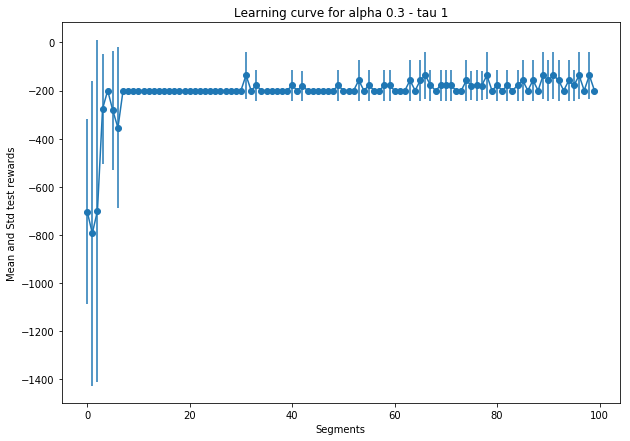

expected_sarsa | alpha 0.5, tau 1.00 | Run  0, Segment  0 | train reward  -507.70, test_reward -830
expected_sarsa | alpha 0.5, tau 1.00 | Run  0, Segment 10 | train reward  -261.50, test_reward -200
expected_sarsa | alpha 0.5, tau 1.00 | Run  0, Segment 20 | train reward  -121.50, test_reward -200
expected_sarsa | alpha 0.5, tau 1.00 | Run  0, Segment 30 | train reward  -115.80, test_reward -200
expected_sarsa | alpha 0.5, tau 1.00 | Run  0, Segment 40 | train reward   -54.80, test_reward -200
expected_sarsa | alpha 0.5, tau 1.00 | Run  0, Segment 50 | train reward  -137.70, test_reward -200
expected_sarsa | alpha 0.5, tau 1.00 | Run  0, Segment 60 | train reward   -94.80, test_reward -200
expected_sarsa | alpha 0.5, tau 1.00 | Run  0, Segment 70 | train reward  -137.90, test_reward -200
expected_sarsa | alpha 0.5, tau 1.00 | Run  0, Segment 80 | train reward  -155.60, test_reward -200
expected_sarsa | alpha 0.5, tau 1.00 | Run  0, Segment 90 | train reward  -138.60, test_reward -200


expected_sarsa | alpha 0.5, tau 1.00 | Run  7, Segment 60 | train reward  -140.00, test_reward -200
expected_sarsa | alpha 0.5, tau 1.00 | Run  7, Segment 70 | train reward   -78.80, test_reward -200
expected_sarsa | alpha 0.5, tau 1.00 | Run  7, Segment 80 | train reward  -134.80, test_reward -200
expected_sarsa | alpha 0.5, tau 1.00 | Run  7, Segment 90 | train reward  -141.50, test_reward -200
expected_sarsa | alpha 0.5, tau 1.00 | Run  7, Segment 99 | train reward  -126.10, test_reward -200
expected_sarsa | alpha 0.5, tau 1.00 | Run  8, Segment  0 | train reward  -496.10, test_reward -839
expected_sarsa | alpha 0.5, tau 1.00 | Run  8, Segment 10 | train reward  -213.60, test_reward -200
expected_sarsa | alpha 0.5, tau 1.00 | Run  8, Segment 20 | train reward  -188.00, test_reward -200
expected_sarsa | alpha 0.5, tau 1.00 | Run  8, Segment 30 | train reward  -143.30, test_reward -200
expected_sarsa | alpha 0.5, tau 1.00 | Run  8, Segment 40 | train reward  -120.60, test_reward -200


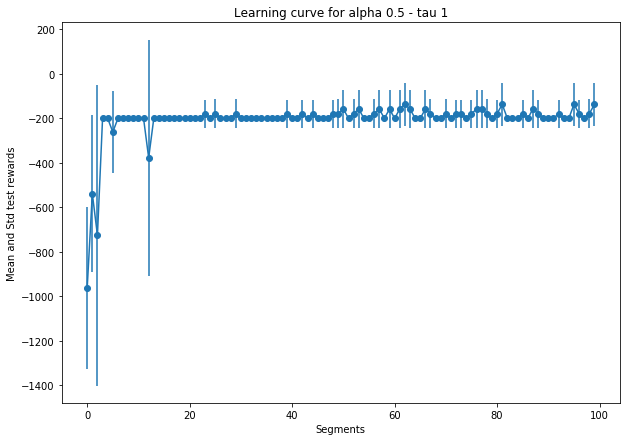

expected_sarsa | alpha 0.8, tau 1.00 | Run  0, Segment  0 | train reward  -452.90, test_reward -974
expected_sarsa | alpha 0.8, tau 1.00 | Run  0, Segment 10 | train reward  -231.20, test_reward -200
expected_sarsa | alpha 0.8, tau 1.00 | Run  0, Segment 20 | train reward  -122.30, test_reward -200
expected_sarsa | alpha 0.8, tau 1.00 | Run  0, Segment 30 | train reward  -117.60, test_reward -200
expected_sarsa | alpha 0.8, tau 1.00 | Run  0, Segment 40 | train reward  -102.00, test_reward -200
expected_sarsa | alpha 0.8, tau 1.00 | Run  0, Segment 50 | train reward  -136.50, test_reward -200
expected_sarsa | alpha 0.8, tau 1.00 | Run  0, Segment 60 | train reward  -121.80, test_reward -200
expected_sarsa | alpha 0.8, tau 1.00 | Run  0, Segment 70 | train reward  -183.60, test_reward -200
expected_sarsa | alpha 0.8, tau 1.00 | Run  0, Segment 80 | train reward  -137.80, test_reward -200
expected_sarsa | alpha 0.8, tau 1.00 | Run  0, Segment 90 | train reward  -107.80, test_reward -200


expected_sarsa | alpha 0.8, tau 1.00 | Run  7, Segment 50 | train reward  -165.30, test_reward -200
expected_sarsa | alpha 0.8, tau 1.00 | Run  7, Segment 60 | train reward  -132.90, test_reward -200
expected_sarsa | alpha 0.8, tau 1.00 | Run  7, Segment 70 | train reward  -143.20, test_reward -200
expected_sarsa | alpha 0.8, tau 1.00 | Run  7, Segment 80 | train reward  -175.90, test_reward -200
expected_sarsa | alpha 0.8, tau 1.00 | Run  7, Segment 90 | train reward  -174.30, test_reward -200
expected_sarsa | alpha 0.8, tau 1.00 | Run  7, Segment 99 | train reward  -200.90, test_reward -200
expected_sarsa | alpha 0.8, tau 1.00 | Run  8, Segment  0 | train reward  -463.20, test_reward -785
expected_sarsa | alpha 0.8, tau 1.00 | Run  8, Segment 10 | train reward  -172.30, test_reward -200
expected_sarsa | alpha 0.8, tau 1.00 | Run  8, Segment 20 | train reward   -99.80, test_reward -200
expected_sarsa | alpha 0.8, tau 1.00 | Run  8, Segment 30 | train reward  -165.60, test_reward -200


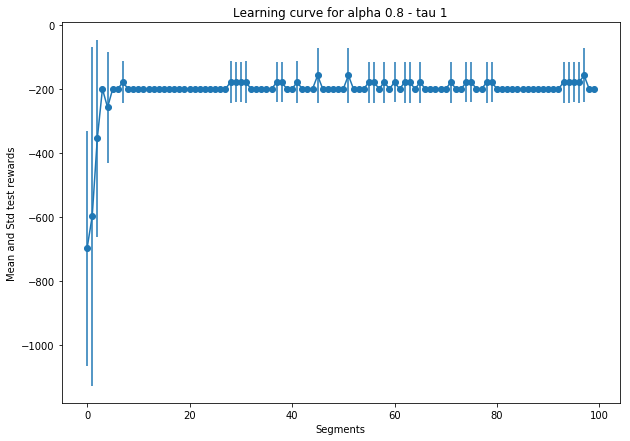

expected_sarsa | alpha 0.3, tau 1.50 | Run  0, Segment  0 | train reward  -511.40, test_reward -200
expected_sarsa | alpha 0.3, tau 1.50 | Run  0, Segment 10 | train reward  -281.50, test_reward -200
expected_sarsa | alpha 0.3, tau 1.50 | Run  0, Segment 20 | train reward  -237.40, test_reward -200
expected_sarsa | alpha 0.3, tau 1.50 | Run  0, Segment 30 | train reward  -231.60, test_reward -200
expected_sarsa | alpha 0.3, tau 1.50 | Run  0, Segment 40 | train reward  -109.90, test_reward -200
expected_sarsa | alpha 0.3, tau 1.50 | Run  0, Segment 50 | train reward  -164.60, test_reward -200
expected_sarsa | alpha 0.3, tau 1.50 | Run  0, Segment 60 | train reward  -137.40, test_reward -200
expected_sarsa | alpha 0.3, tau 1.50 | Run  0, Segment 70 | train reward  -160.50, test_reward -200
expected_sarsa | alpha 0.3, tau 1.50 | Run  0, Segment 80 | train reward  -196.10, test_reward -200
expected_sarsa | alpha 0.3, tau 1.50 | Run  0, Segment 90 | train reward  -169.40, test_reward -200


expected_sarsa | alpha 0.3, tau 1.50 | Run  7, Segment 50 | train reward  -126.40, test_reward -200
expected_sarsa | alpha 0.3, tau 1.50 | Run  7, Segment 60 | train reward  -118.60, test_reward -200
expected_sarsa | alpha 0.3, tau 1.50 | Run  7, Segment 70 | train reward  -123.90, test_reward -200
expected_sarsa | alpha 0.3, tau 1.50 | Run  7, Segment 80 | train reward  -115.10, test_reward -200
expected_sarsa | alpha 0.3, tau 1.50 | Run  7, Segment 90 | train reward  -120.70, test_reward -200
expected_sarsa | alpha 0.3, tau 1.50 | Run  7, Segment 99 | train reward  -152.00, test_reward -200
expected_sarsa | alpha 0.3, tau 1.50 | Run  8, Segment  0 | train reward  -533.00, test_reward -839
expected_sarsa | alpha 0.3, tau 1.50 | Run  8, Segment 10 | train reward  -262.90, test_reward -200
expected_sarsa | alpha 0.3, tau 1.50 | Run  8, Segment 20 | train reward  -185.90, test_reward -200
expected_sarsa | alpha 0.3, tau 1.50 | Run  8, Segment 30 | train reward  -177.00, test_reward -200


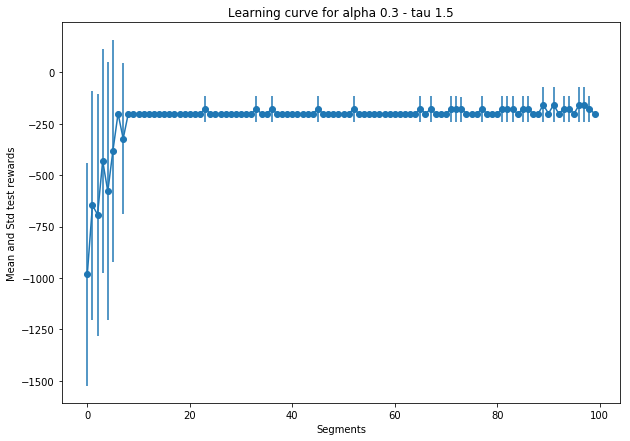

expected_sarsa | alpha 0.5, tau 1.50 | Run  0, Segment  0 | train reward  -516.80, test_reward -1541
expected_sarsa | alpha 0.5, tau 1.50 | Run  0, Segment 10 | train reward  -239.20, test_reward -200
expected_sarsa | alpha 0.5, tau 1.50 | Run  0, Segment 20 | train reward  -174.70, test_reward -200
expected_sarsa | alpha 0.5, tau 1.50 | Run  0, Segment 30 | train reward  -220.20, test_reward -200
expected_sarsa | alpha 0.5, tau 1.50 | Run  0, Segment 40 | train reward  -144.90, test_reward -200
expected_sarsa | alpha 0.5, tau 1.50 | Run  0, Segment 50 | train reward  -152.30, test_reward -200
expected_sarsa | alpha 0.5, tau 1.50 | Run  0, Segment 60 | train reward  -147.40, test_reward -200
expected_sarsa | alpha 0.5, tau 1.50 | Run  0, Segment 70 | train reward  -143.20, test_reward -200
expected_sarsa | alpha 0.5, tau 1.50 | Run  0, Segment 80 | train reward  -135.00, test_reward -200
expected_sarsa | alpha 0.5, tau 1.50 | Run  0, Segment 90 | train reward  -168.10, test_reward -200

expected_sarsa | alpha 0.5, tau 1.50 | Run  7, Segment 50 | train reward  -108.60, test_reward -200
expected_sarsa | alpha 0.5, tau 1.50 | Run  7, Segment 60 | train reward  -146.30, test_reward -200
expected_sarsa | alpha 0.5, tau 1.50 | Run  7, Segment 70 | train reward  -170.90, test_reward 14
expected_sarsa | alpha 0.5, tau 1.50 | Run  7, Segment 80 | train reward  -118.00, test_reward -200
expected_sarsa | alpha 0.5, tau 1.50 | Run  7, Segment 90 | train reward  -179.40, test_reward -200
expected_sarsa | alpha 0.5, tau 1.50 | Run  7, Segment 99 | train reward  -194.20, test_reward -200
expected_sarsa | alpha 0.5, tau 1.50 | Run  8, Segment  0 | train reward  -516.10, test_reward -1082
expected_sarsa | alpha 0.5, tau 1.50 | Run  8, Segment 10 | train reward  -209.10, test_reward -200
expected_sarsa | alpha 0.5, tau 1.50 | Run  8, Segment 20 | train reward  -151.90, test_reward -200
expected_sarsa | alpha 0.5, tau 1.50 | Run  8, Segment 30 | train reward  -223.20, test_reward -200
e

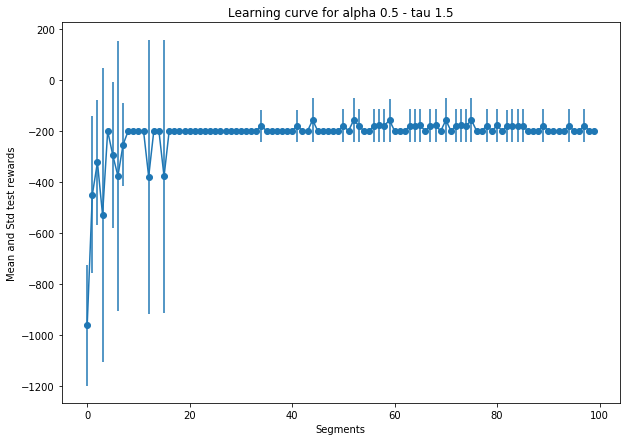

expected_sarsa | alpha 0.8, tau 1.50 | Run  0, Segment  0 | train reward  -447.50, test_reward -794
expected_sarsa | alpha 0.8, tau 1.50 | Run  0, Segment 10 | train reward  -204.30, test_reward -200
expected_sarsa | alpha 0.8, tau 1.50 | Run  0, Segment 20 | train reward  -127.60, test_reward -200
expected_sarsa | alpha 0.8, tau 1.50 | Run  0, Segment 30 | train reward  -188.10, test_reward -200
expected_sarsa | alpha 0.8, tau 1.50 | Run  0, Segment 40 | train reward  -164.70, test_reward -200
expected_sarsa | alpha 0.8, tau 1.50 | Run  0, Segment 50 | train reward  -164.00, test_reward -200
expected_sarsa | alpha 0.8, tau 1.50 | Run  0, Segment 60 | train reward  -164.40, test_reward -200
expected_sarsa | alpha 0.8, tau 1.50 | Run  0, Segment 70 | train reward  -172.20, test_reward -200
expected_sarsa | alpha 0.8, tau 1.50 | Run  0, Segment 80 | train reward  -145.70, test_reward -200
expected_sarsa | alpha 0.8, tau 1.50 | Run  0, Segment 90 | train reward  -143.80, test_reward -200


expected_sarsa | alpha 0.8, tau 1.50 | Run  7, Segment 50 | train reward  -165.00, test_reward -200
expected_sarsa | alpha 0.8, tau 1.50 | Run  7, Segment 60 | train reward  -132.70, test_reward -200
expected_sarsa | alpha 0.8, tau 1.50 | Run  7, Segment 70 | train reward  -149.70, test_reward -200
expected_sarsa | alpha 0.8, tau 1.50 | Run  7, Segment 80 | train reward  -166.70, test_reward -200
expected_sarsa | alpha 0.8, tau 1.50 | Run  7, Segment 90 | train reward  -107.00, test_reward -200
expected_sarsa | alpha 0.8, tau 1.50 | Run  7, Segment 99 | train reward  -182.10, test_reward 14
expected_sarsa | alpha 0.8, tau 1.50 | Run  8, Segment  0 | train reward  -489.60, test_reward -695
expected_sarsa | alpha 0.8, tau 1.50 | Run  8, Segment 10 | train reward  -170.70, test_reward -200
expected_sarsa | alpha 0.8, tau 1.50 | Run  8, Segment 20 | train reward  -152.30, test_reward -200
expected_sarsa | alpha 0.8, tau 1.50 | Run  8, Segment 30 | train reward  -178.40, test_reward -200
ex

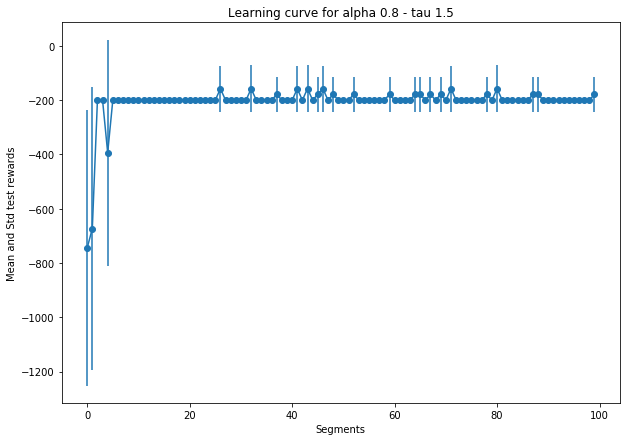

In [8]:
agents = ['expected_sarsa']
for agent in agents:
    agent_train_rewards = np.zeros(shape=(len(temperatures), len(learning_rates)))
    agent_test_rewards = np.zeros_like(agent_train_rewards)
    for temp in temperatures:
        for learning_rate in learning_rates:
            agent_object = TaxiEnv(agent, learning_rate, temp, env, gamma=0.9)
            train_rewards, test_rewards, avg_test, std_test = agent_object.train(print_trace=True)
            agent_train_rewards[temperatures.index(temp)][learning_rates.index(learning_rate)] = train_rewards
            agent_test_rewards[temperatures.index(temp)][learning_rates.index(learning_rate)] = test_rewards
            
            plt.rcParams['figure.figsize'] = [15, 15]
            plot_error(np.arange(100), avg_test, std_test, learning_rate, temp)

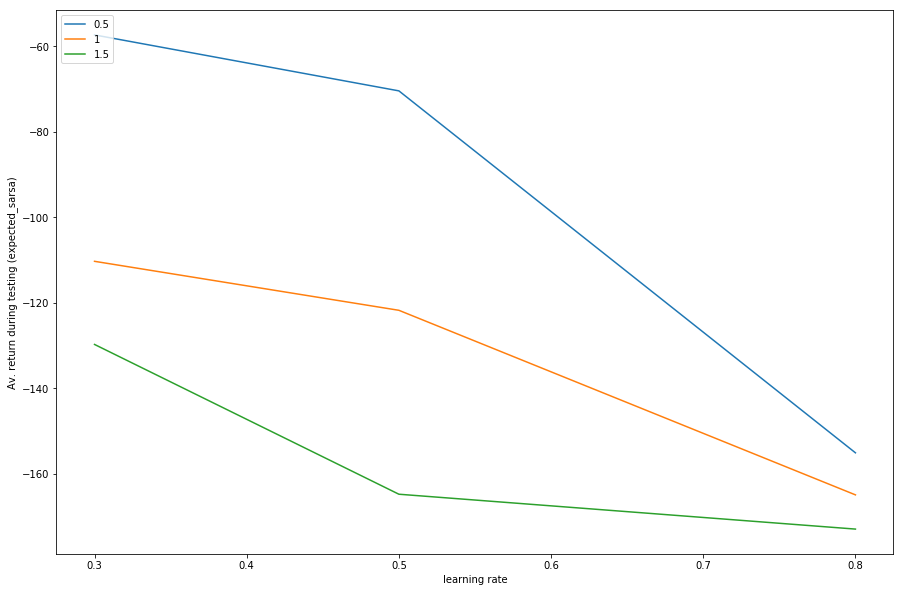

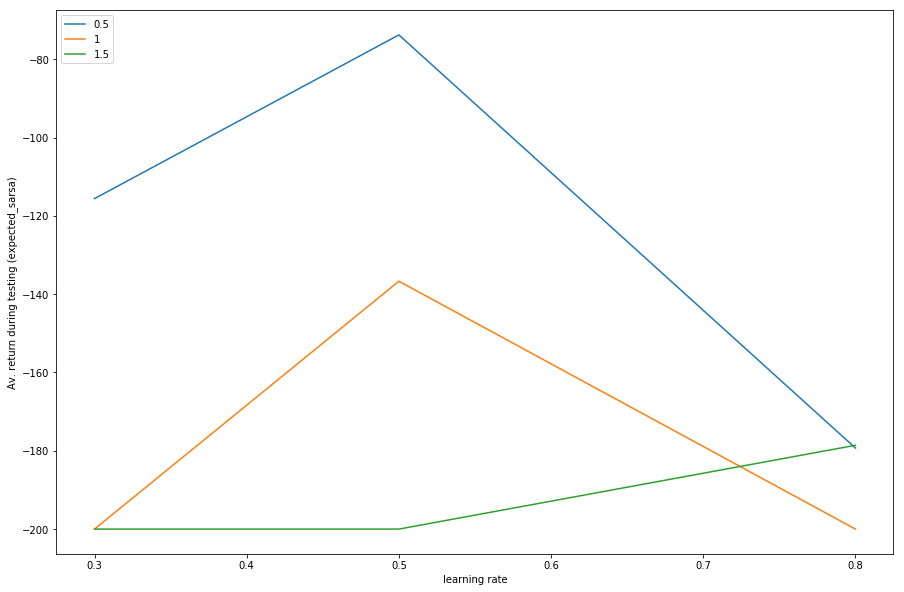

<Figure size 1080x720 with 0 Axes>

In [13]:
# plots for 'q_learning' training and test
plt.rcParams['figure.figsize'] = [15, 10]
    
plot_graph(learning_rates, agent_train_rewards, temperatures, 'learning rate',
           'Av. return during testing ('+agent+')', 'av_return_l_rate_testing_'+agent+'.png')
plot_graph(learning_rates, agent_test_rewards, temperatures, 'learning rate',
           'Av. return during testing ('+agent+')', 'av_return_l_rate_testing_'+agent+'.png')